Goal:
Take any image, utilize the models and validations to detect the keypoints of hte court, detect the player, detect the player makes and misses and we mark it on the view transformed image. 

Use homography to transform keypoints on the court into a 2d court and detect where players are on the court and project them onto the 2d court. I want to learn exactly how, so I can try to automate this.

I want to automate the homography portion by detecting everything it can and then creating the homography and inputting all the players seen on the court onto the 2d court and it highlights a different color on homography when a make or miss happens. 

In [1]:
%%writefile api/src/cv/config.py
"""
Central config for the CV shot pipeline.
- Keeps all IDs, thresholds, and paths in one place
- Never hardcodes API keys; uses env vars (ROBOFLOW_API_KEY or INFERENCE_API_KEY)
"""
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
import os
from typing import Optional, Tuple
import supervision as sv
from sports import MeasurementUnit
from sports.basketball import CourtConfiguration, League

@dataclass(frozen=True)
class CVConfig:
    # --- Workspace & IO ---
    workspace_dir: Path = Path(os.getenv("WORKSPACE_DIR", "/workspace"))
    data_dir: Path = workspace_dir / "api/src/cv/data"

    video_dir: Path = data_dir / "video"
    output_dir: Path = video_dir / "outputs"

    source_video_path: Path = Path(
        os.getenv(
            "SOURCE_VIDEO_PATH",
            "/workspace/api/src/cv/data/video/boston-celtics-new-york-knicks-game-1/"
            "boston-celtics-new-york-knicks-game-1-q1-03.16-03.11.mp4",
        )
    )

    # Optional image input (single-still pipeline)
    images_dir: Path = data_dir / "images"
    image_output_dir: Path = images_dir / "outputs"

    # --- Models (Roboflow Inference) ---
    player_model_id: str = os.getenv(
        "PLAYER_DETECTION_MODEL_ID", "basketball-player-detection-3-ycjdo/4"
    )
    court_model_id: str = os.getenv(
        "COURT_DETECTION_MODEL_ID", "basketball-court-detection-2/14"
    )

    # --- Thresholds ---
    confidence_threshold: float = 0.30
    iou_threshold: float = 0.70
    keypoint_conf_threshold: float = 0.50
    detection_confidence_court: float = 0.30
    min_keypoints_required: int = 4

    # Homography quality gates
    homography_rmse_court_max: float = float(os.getenv("H_RMSE_COURT_MAX", "1.5"))  # feet
    homography_rmse_image_max: float = float(os.getenv("H_RMSE_IMAGE_MAX", "5.0"))  # pixels
    use_cached_transform_frames: int = int(os.getenv("USE_CACHED_TRANSFORM_FRAMES", "99999"))

    # --- Event logic ---
    reset_time_seconds: float = 1.7
    min_between_starts_seconds: float = 0.5
    cooldown_after_made_seconds: float = 0.5

    # --- Classes ---
    BALL_IN_BASKET_CLASS_ID: int = 1
    JUMP_SHOT_CLASS_ID: int = 5
    LAYUP_DUNK_CLASS_ID: int = 6

    # Optional referee hints (id and/or label match if your model exposes them)
    referee_class_ids: Tuple[int, ...] = tuple(int(x) for x in os.getenv("REFEREE_CLASS_IDS", "").split(",") if x.strip().isdigit())
    referee_labels: Tuple[str, ...] = tuple(x.strip().lower() for x in os.getenv("REFEREE_LABELS", "referee,official").split(",") if x.strip())

    # --- Court drawing ---
    court_scale: int = 20
    court_padding: int = 50
    court_line_thickness: int = 4

    # --- Smoothing ---
    keypoint_smoothing_len: int = 3

    # --- Colors ---
    palette: sv.ColorPalette = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
        "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00",
    ])
    magenta: sv.Color = sv.Color.from_hex("#FF1493")
    cyan: sv.Color = sv.Color.from_hex("#00BFFF")

    # Players (teams) + referee colors
    team_a_color: sv.Color = sv.Color.from_hex("#1F77B4")  # blue
    team_b_color: sv.Color = sv.Color.from_hex("#FF7F0E")  # orange
    referee_color: sv.Color = sv.Color.from_hex("#808080") # grey

    # Shots (made/miss)
    attempt_color: sv.Color = sv.Color.from_hex("#1F77B4")  # legacy fallback
    made_color: sv.Color = sv.Color.from_hex("#007A33")     # green
    miss_color: sv.Color = sv.Color.from_hex("#850101")     # red

    # --- League/Court ---
    court_config: CourtConfiguration = CourtConfiguration(
        league=League.NBA, measurement_unit=MeasurementUnit.FEET
    )

    # --- Smoke test runtime ---
    smoke_max_frames: Optional[int] = 200  # None = full video

    # --- Debug / Smoke options ---
    start_frame_index: int = int(os.getenv("START_FRAME_INDEX", "65"))
    save_debug_stage_images: bool = os.getenv("SAVE_DEBUG_STAGE_IMAGES", "1") == "1"
    enable_ffmpeg_compression: bool = os.getenv("ENABLE_FFMPEG_COMPRESSION", "0") == "1"

    # --- Event-frame saving ---
    save_event_frames: bool = os.getenv("SAVE_EVENT_FRAMES", "1") == "1"
    event_frame_limit: int = int(os.getenv("EVENT_FRAME_LIMIT", "12"))

    # --- UI / behavior toggles ---
    show_images: bool = os.getenv("SHOW_IMAGES", "0") == "1"

    # Fail fast by default
    strict_fail: bool = os.getenv("STRICT_FAIL", "1") == "1"

    # Write a final single PNG summary (overhead court) per video
    emit_summary_image: bool = os.getenv("EMIT_SUMMARY_IMAGE", "1") == "1"

    preview_images_in_terminal: bool = os.getenv("PREVIEW_IMAGES_IN_TERMINAL", "0") == "1"
    terminal_preview_max_width: int = int(os.getenv("TERMINAL_PREVIEW_MAX_WIDTH", "80"))

    # --- add these fields inside CVConfig dataclass ---
    # Homography robustness / debugging
    enable_robust_homography: bool = os.getenv("ENABLE_ROBUST_HOMO", "1") == "1"
    ransac_reproj_thresh_px: float = float(os.getenv("RANSAC_REPROJ_THRESH_PX", "10.0"))
    min_inlier_ratio: float = float(os.getenv("HOMO_MIN_INLIER_RATIO", "0.5"))  # relative to kept keypoints
    min_spread_px: float = float(os.getenv("HOMO_MIN_SPREAD_PX", "80.0"))       # ensure not degenerate cluster

    # Homography RANSAC thresholds (destination-units explicit)
    ransac_reproj_thresh_court_ft: float = float(os.getenv("RANSAC_REPROJ_THRESH_COURT_FT", "1.0"))
    ransac_reproj_thresh_image_px: float = float(os.getenv("RANSAC_REPROJ_THRESH_IMAGE_PX", "5.0"))

    # --- Homography proof / visualization ---
    homography_proof_enable: bool = os.getenv("HOMOGRAPHY_PROOF_ENABLE", "1") == "1"
    homography_grid_step_ft: float = float(os.getenv("HOMOGRAPHY_GRID_STEP_FT", "5.0"))

# ---- Helpers ----

def ensure_dirs(cfg: CVConfig) -> None:
    cfg.output_dir.mkdir(parents=True, exist_ok=True)


def resolve_api_key() -> str:
    """Return an API key from env, supporting either ROBOFLOW_API_KEY or INFERENCE_API_KEY."""
    api_key = os.getenv("ROBOFLOW_API_KEY") or os.getenv("INFERENCE_API_KEY")
    if not api_key:
        raise RuntimeError(
            "Missing API key. Set ROBOFLOW_API_KEY or INFERENCE_API_KEY in the environment."
        )
    return api_key


def _set_inference_feature_flags() -> None:
    """
    Disable optional models we do not use so 'inference' doesn't warn about missing extras.
    This does NOT affect the player/court models.
    """
    os.environ.setdefault("QWEN_2_5_ENABLED", "False")
    os.environ.setdefault("CORE_MODEL_SAM_ENABLED", "False")
    os.environ.setdefault("CORE_MODEL_SAM2_ENABLED", "False")
    os.environ.setdefault("CORE_MODEL_CLIP_ENABLED", "False")
    os.environ.setdefault("CORE_MODEL_GAZE_ENABLED", "False")
    os.environ.setdefault("SMOLVLM2_ENABLED", "False")
    os.environ.setdefault("CORE_MODEL_GROUNDINGDINO_ENABLED", "False")
    os.environ.setdefault("CORE_MODEL_YOLO_WORLD_ENABLED", "False")
    os.environ.setdefault("CORE_MODEL_PE_ENABLED", "False")


def load_models(cfg: CVConfig):
    """Lazy import to avoid heavy import at module import time."""
    _set_inference_feature_flags()
    from inference import get_model  # type: ignore

    api_key = resolve_api_key()
    player_model = get_model(model_id=cfg.player_model_id, api_key=api_key)
    court_model = get_model(model_id=cfg.court_model_id, api_key=api_key)
    return player_model, court_model


def court_base_image(cfg: CVConfig):
    from sports.basketball import draw_court

    base = draw_court(
        config=cfg.court_config,
        scale=cfg.court_scale,
        padding=cfg.court_padding,
        line_thickness=cfg.court_line_thickness,
    )
    return base

Overwriting api/src/cv/config.py


[SMOKE] Saving stage images...
[SMOKE] stage_all_detections: /workspace/api/src/cv/data/video/boston-celtics-new-york-knicks-game-1/boston-celtics-new-york-knicks-game-1-q1-03.16-03.11-stage_all_detections.jpg
[SMOKE] stage_jump_shots: /workspace/api/src/cv/data/video/boston-celtics-new-york-knicks-game-1/boston-celtics-new-york-knicks-game-1-q1-03.16-03.11-stage_jump_shots.jpg
[SMOKE] stage_keypoints: /workspace/api/src/cv/data/video/boston-celtics-new-york-knicks-game-1/boston-celtics-new-york-knicks-game-1-q1-03.16-03.11-stage_keypoints.jpg
[DEBUG][homography] conf_filter: kept=12/33 (thr=0.50; min_req=4)
[DEBUG][homography][ransac] inliers=7/12 spread=(1174.0,626.0) dual=True thr_ft=1.0 thr_px=5.0 reason=None
[DEBUG][homography] pairs_used=7/12 RMSE court=0.082ft  image=1.21px (limits: 1.500ft/5.00px)
[DEBUG][homography][matrix] H(img→court):
    [ 0.043006   0.052347  -55.670315]
    [-0.013561   0.153654  -59.296503]
    [-0.000052   0.001023   1.000000]
[DEBUG][homography][matri

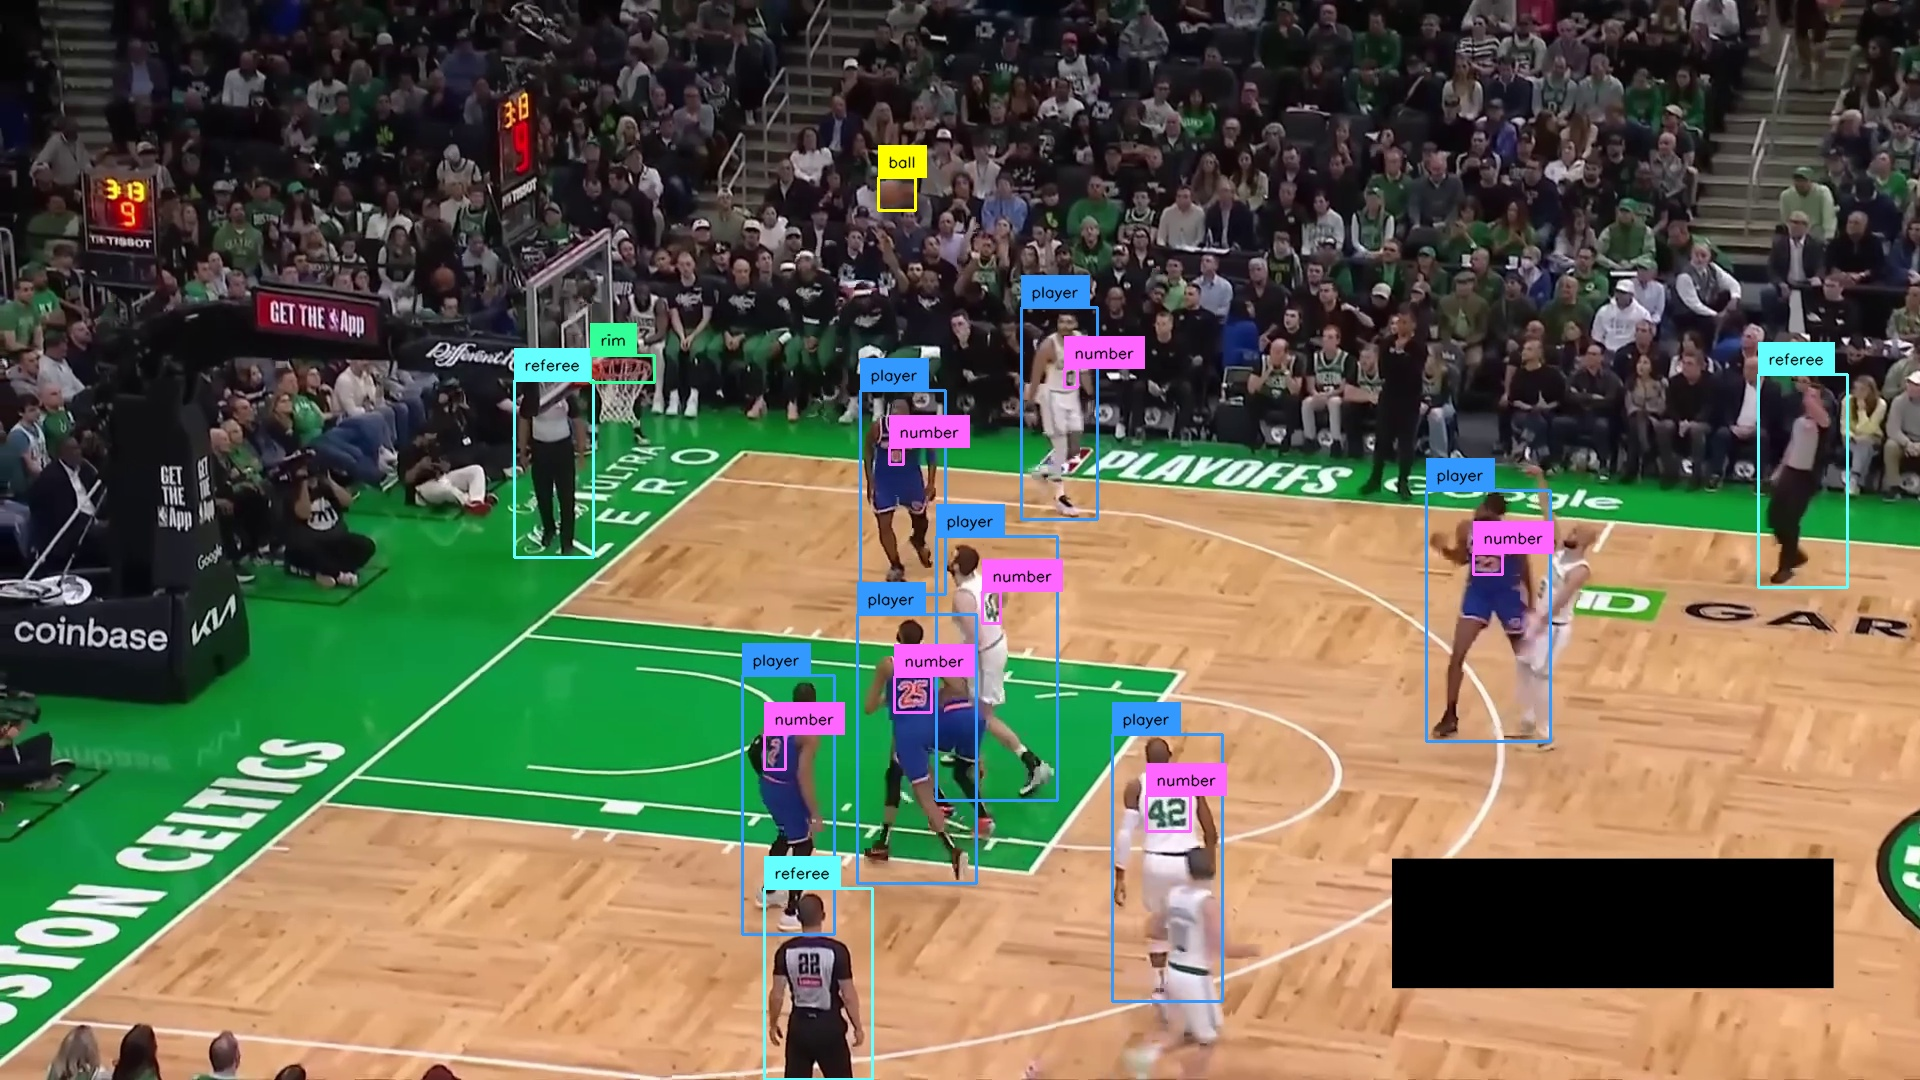

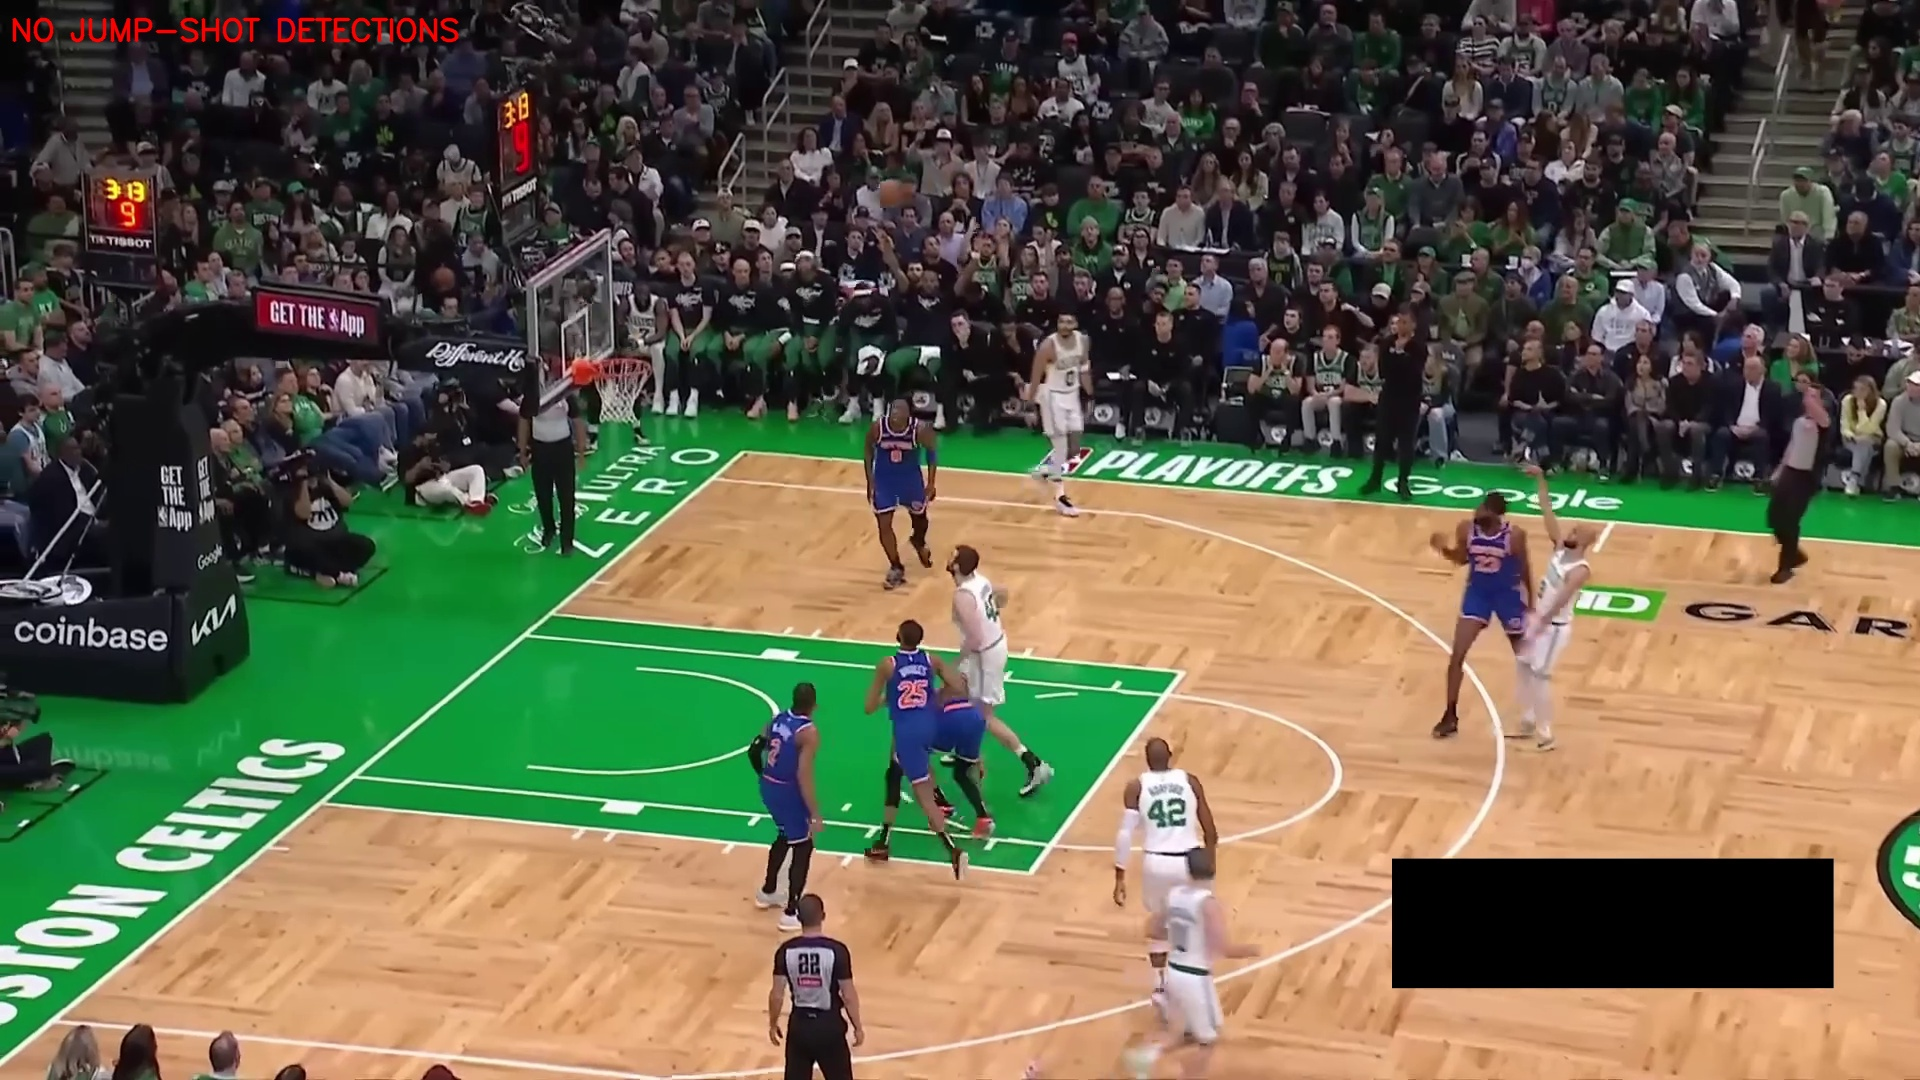

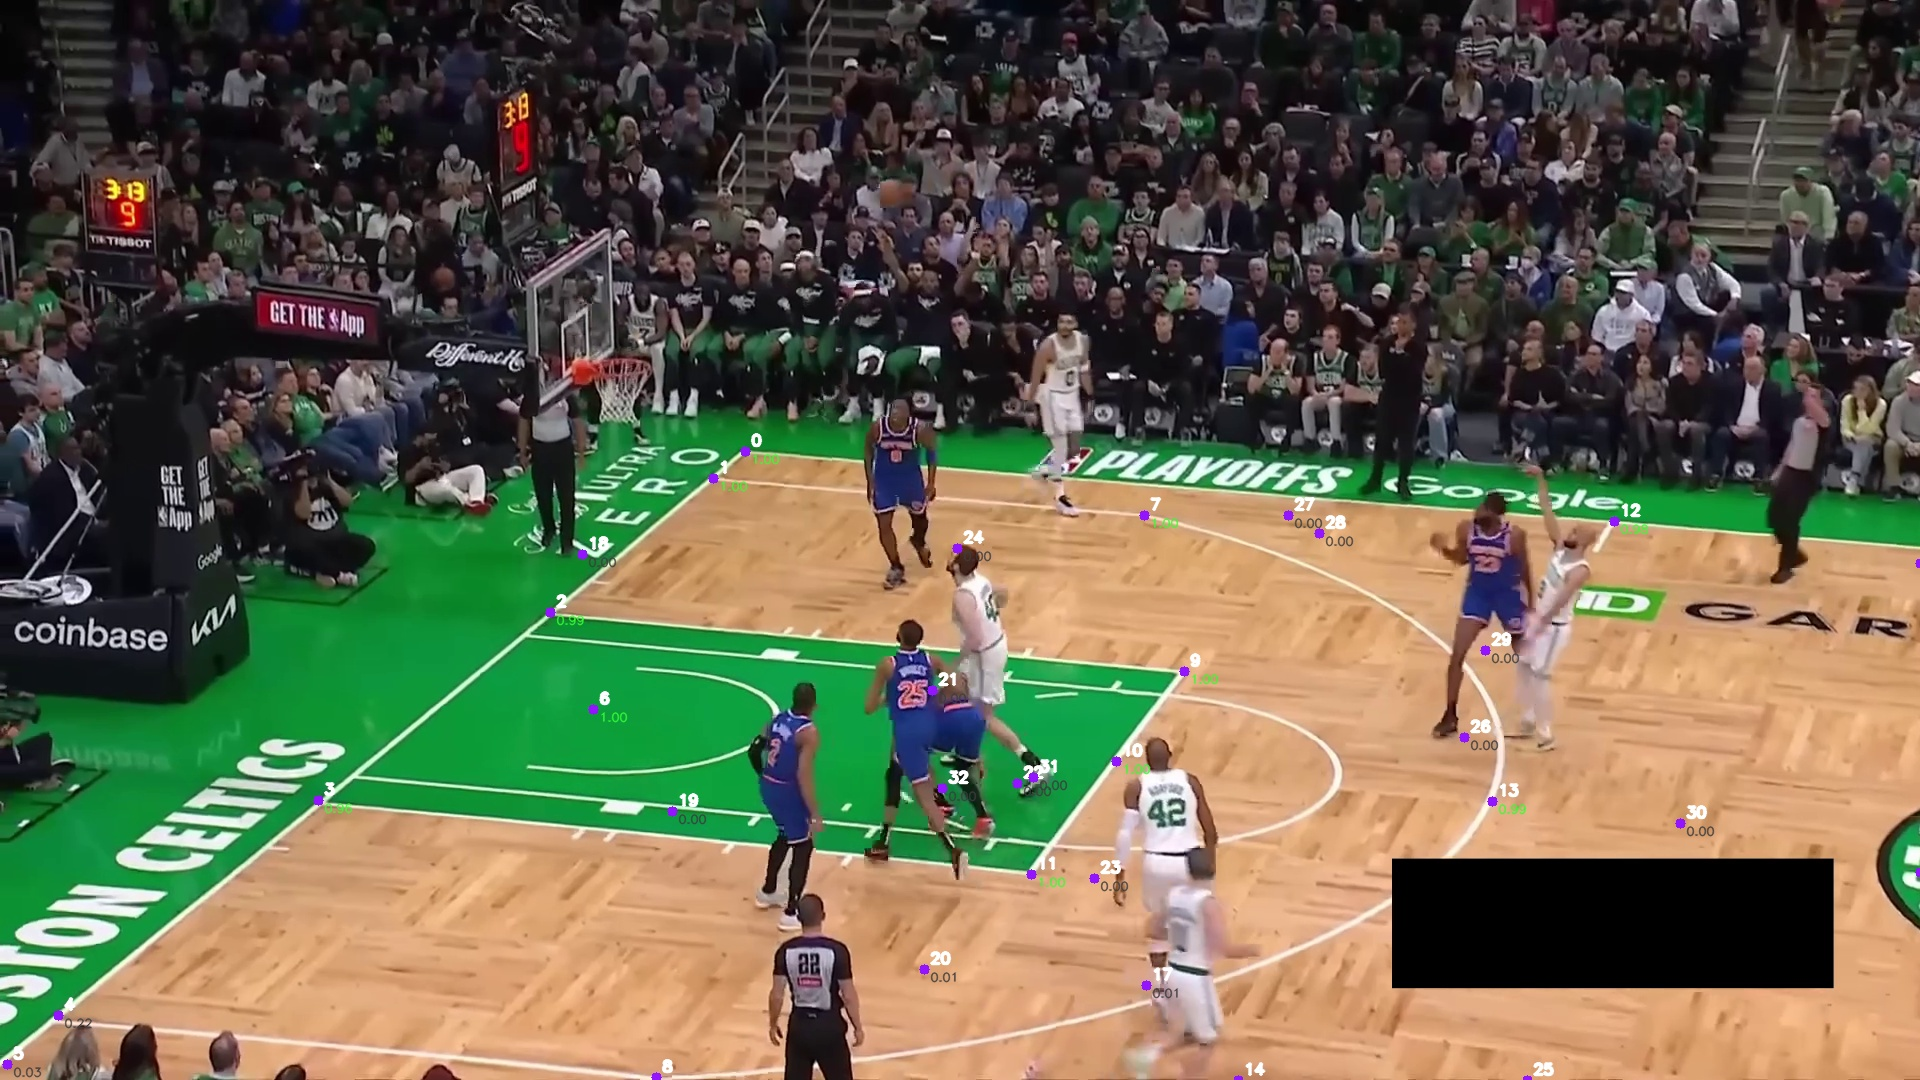

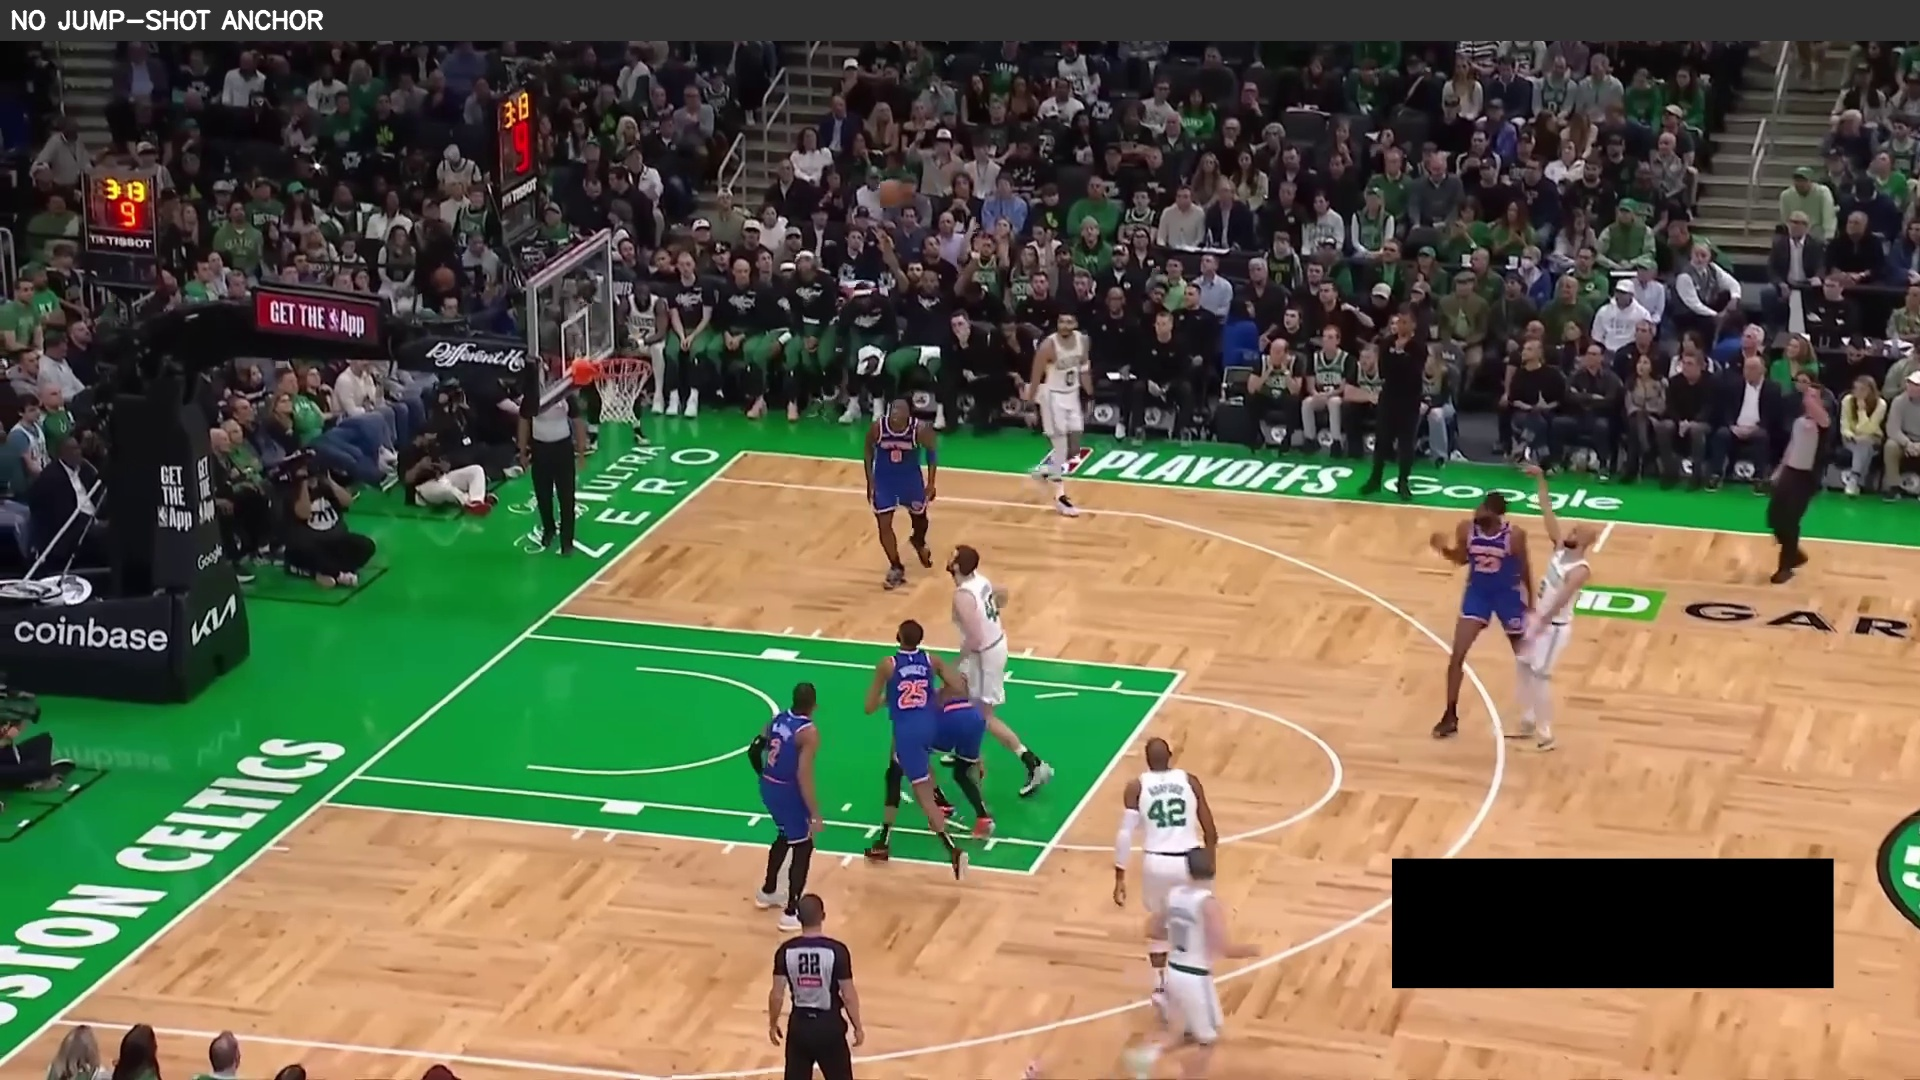

[SMOKE] Processing: /workspace/api/src/cv/data/video/boston-celtics-new-york-knicks-game-1/boston-celtics-new-york-knicks-game-1-q1-03.16-03.11.mp4
[DEBUG][homography] conf_filter: kept=12/33 (thr=0.50; min_req=4)
[DEBUG][homography][ransac] inliers=7/12 spread=(802.0,381.0) dual=True thr_ft=1.0 thr_px=5.0 reason=None
[DEBUG][homography] pairs_used=7/12 RMSE court=0.109ft  image=1.53px (limits: 1.500ft/5.00px)
[DEBUG][homography][matrix] H(img→court):
    [ 0.040438   0.049887  -35.021751]
    [-0.011165   0.143597  -29.796545]
    [-0.000038   0.000936   1.000000]
[DEBUG][homography][matrix] H^-1(court→img):
    [ 22.200614  -10.702543   458.605584]
    [ 1.590518   5.064440   206.605521]
    [-0.000654  -0.005144   0.823834]


[DEBUG][homography] conf_filter: kept=12/33 (thr=0.50; min_req=4)
[DEBUG][homography][ransac] inliers=7/12 spread=(803.0,381.5) dual=True thr_ft=1.0 thr_px=5.0 reason=None
[DEBUG][homography] pairs_used=7/12 RMSE court=0.106ft  image=1.48px (limits: 1.500ft/5.00px)
[DEBUG][homography][matrix] H(img→court):
    [ 0.040483   0.049857  -35.053134]
    [-0.011169   0.143729  -29.867047]
    [-0.000039   0.000943   1.000000]
[DEBUG][homography][matrix] H^-1(court→img):
    [ 22.186738  -10.700593   458.119597]
    [ 1.590677   5.050785   206.610236]
    [-0.000642  -0.005174   0.822947]
[DEBUG][homography] conf_filter: kept=12/33 (thr=0.50; min_req=4)
[DEBUG][homography][ransac] inliers=7/12 spread=(803.7,382.3) dual=True thr_ft=1.0 thr_px=5.0 reason=None
[DEBUG][homography] pairs_used=7/12 RMSE court=0.109ft  image=1.53px (limits: 1.500ft/5.00px)
[DEBUG][homography][matrix] H(img→court):
    [ 0.040256   0.049513  -34.863965]
    [-0.011211   0.142869  -29.654317]
    [-0.000042   0.000934

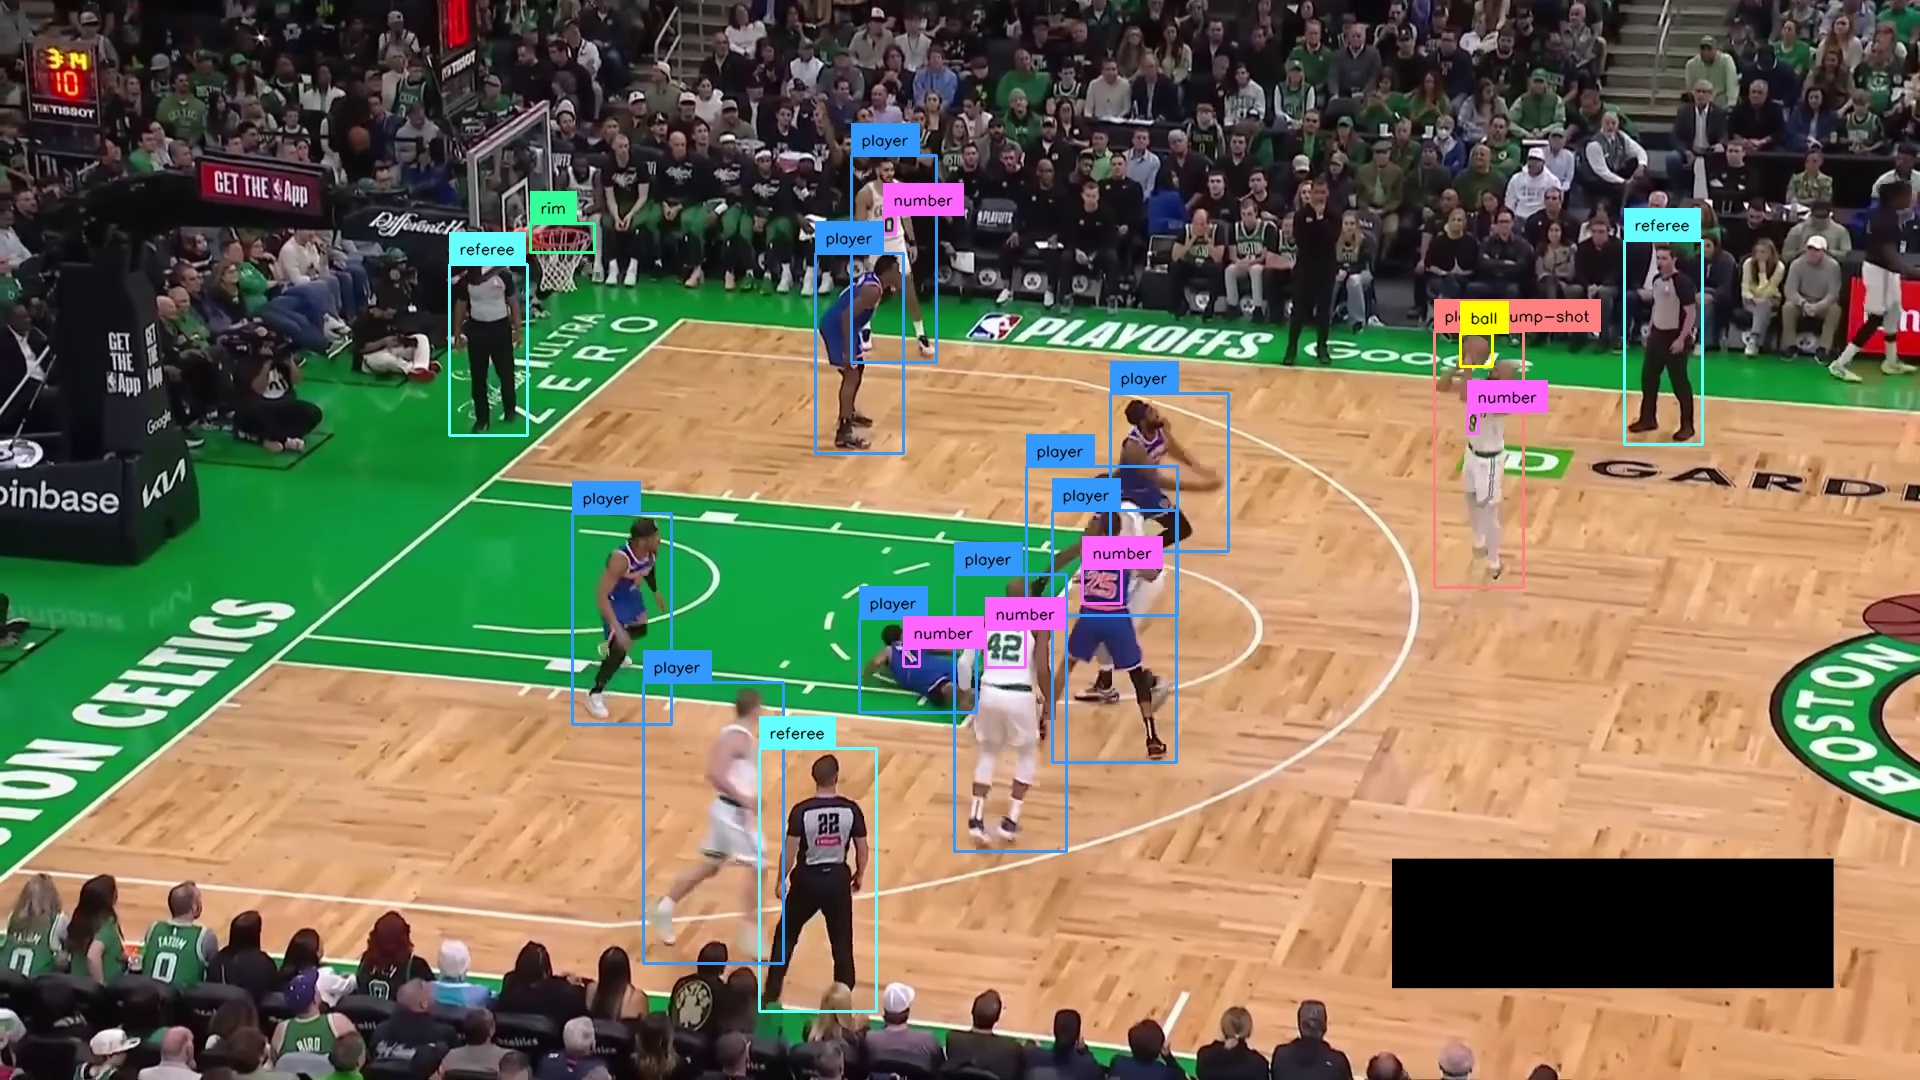

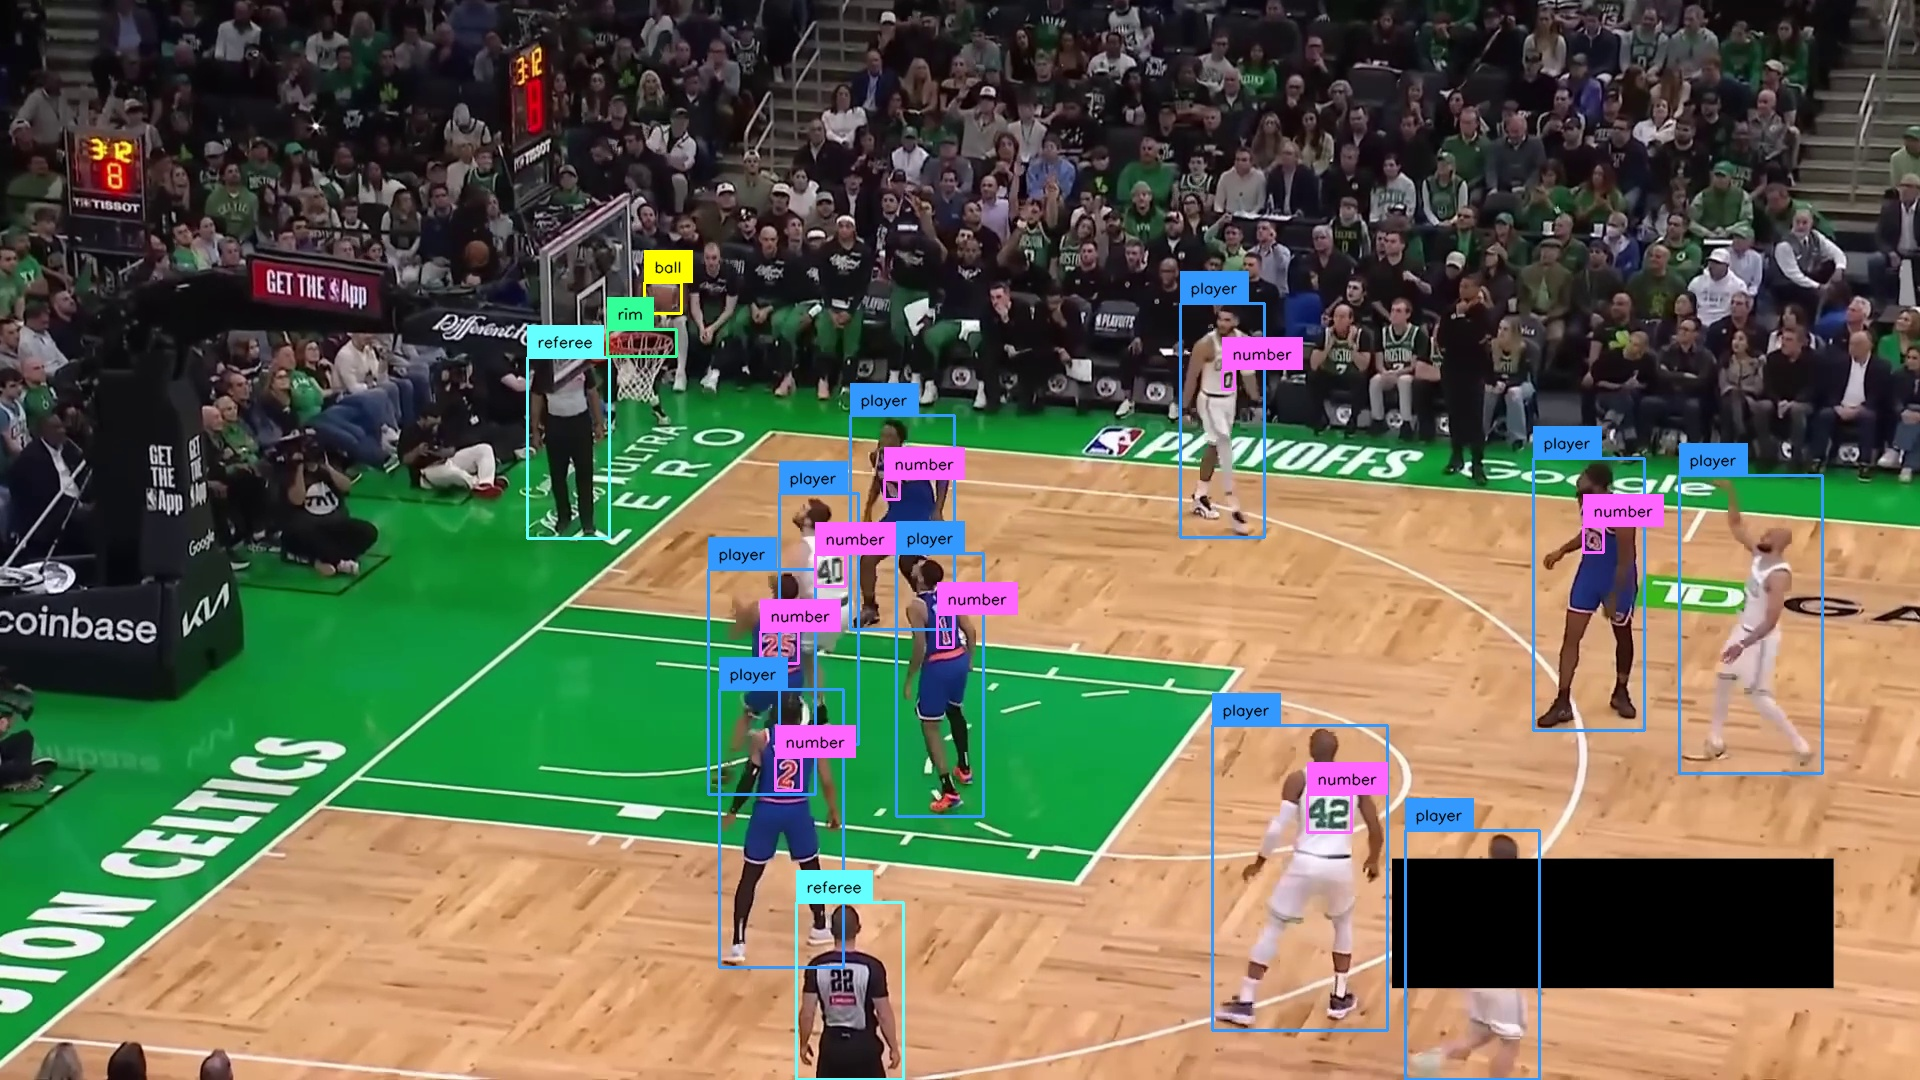

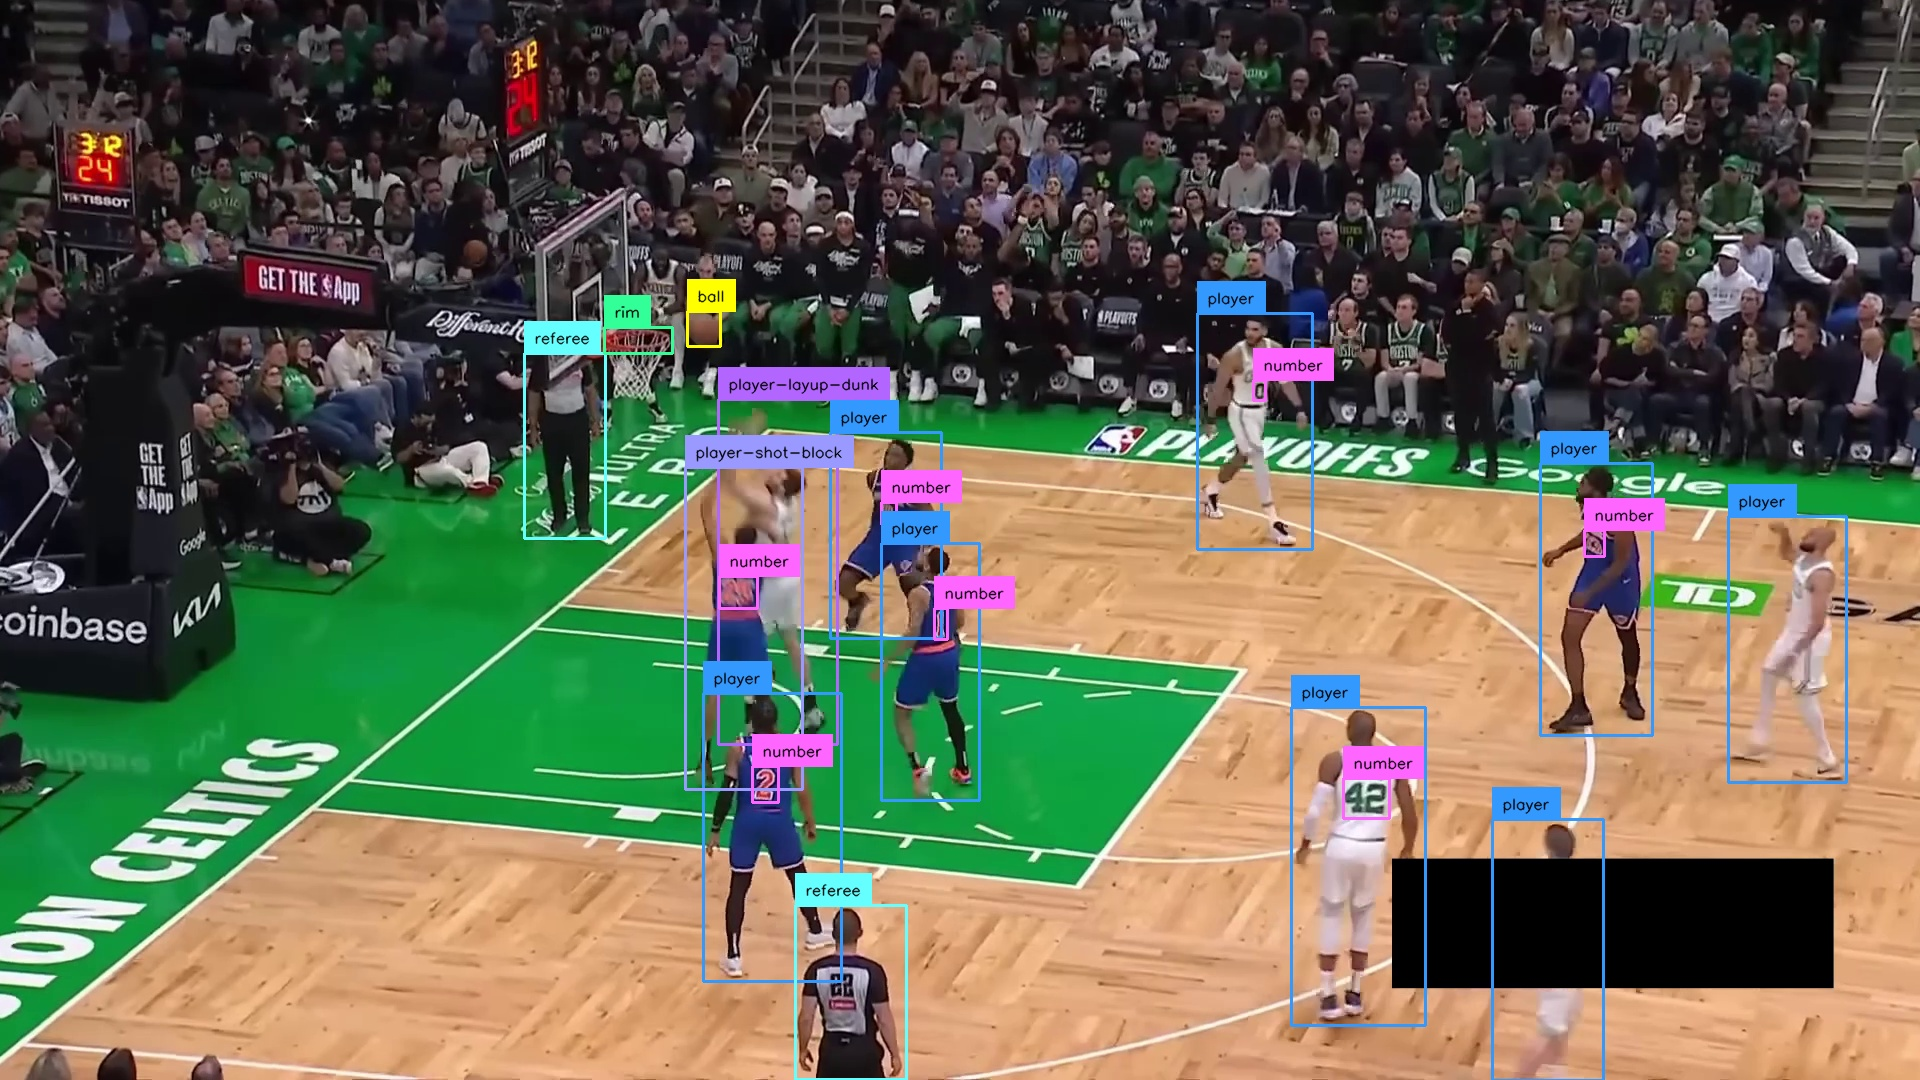

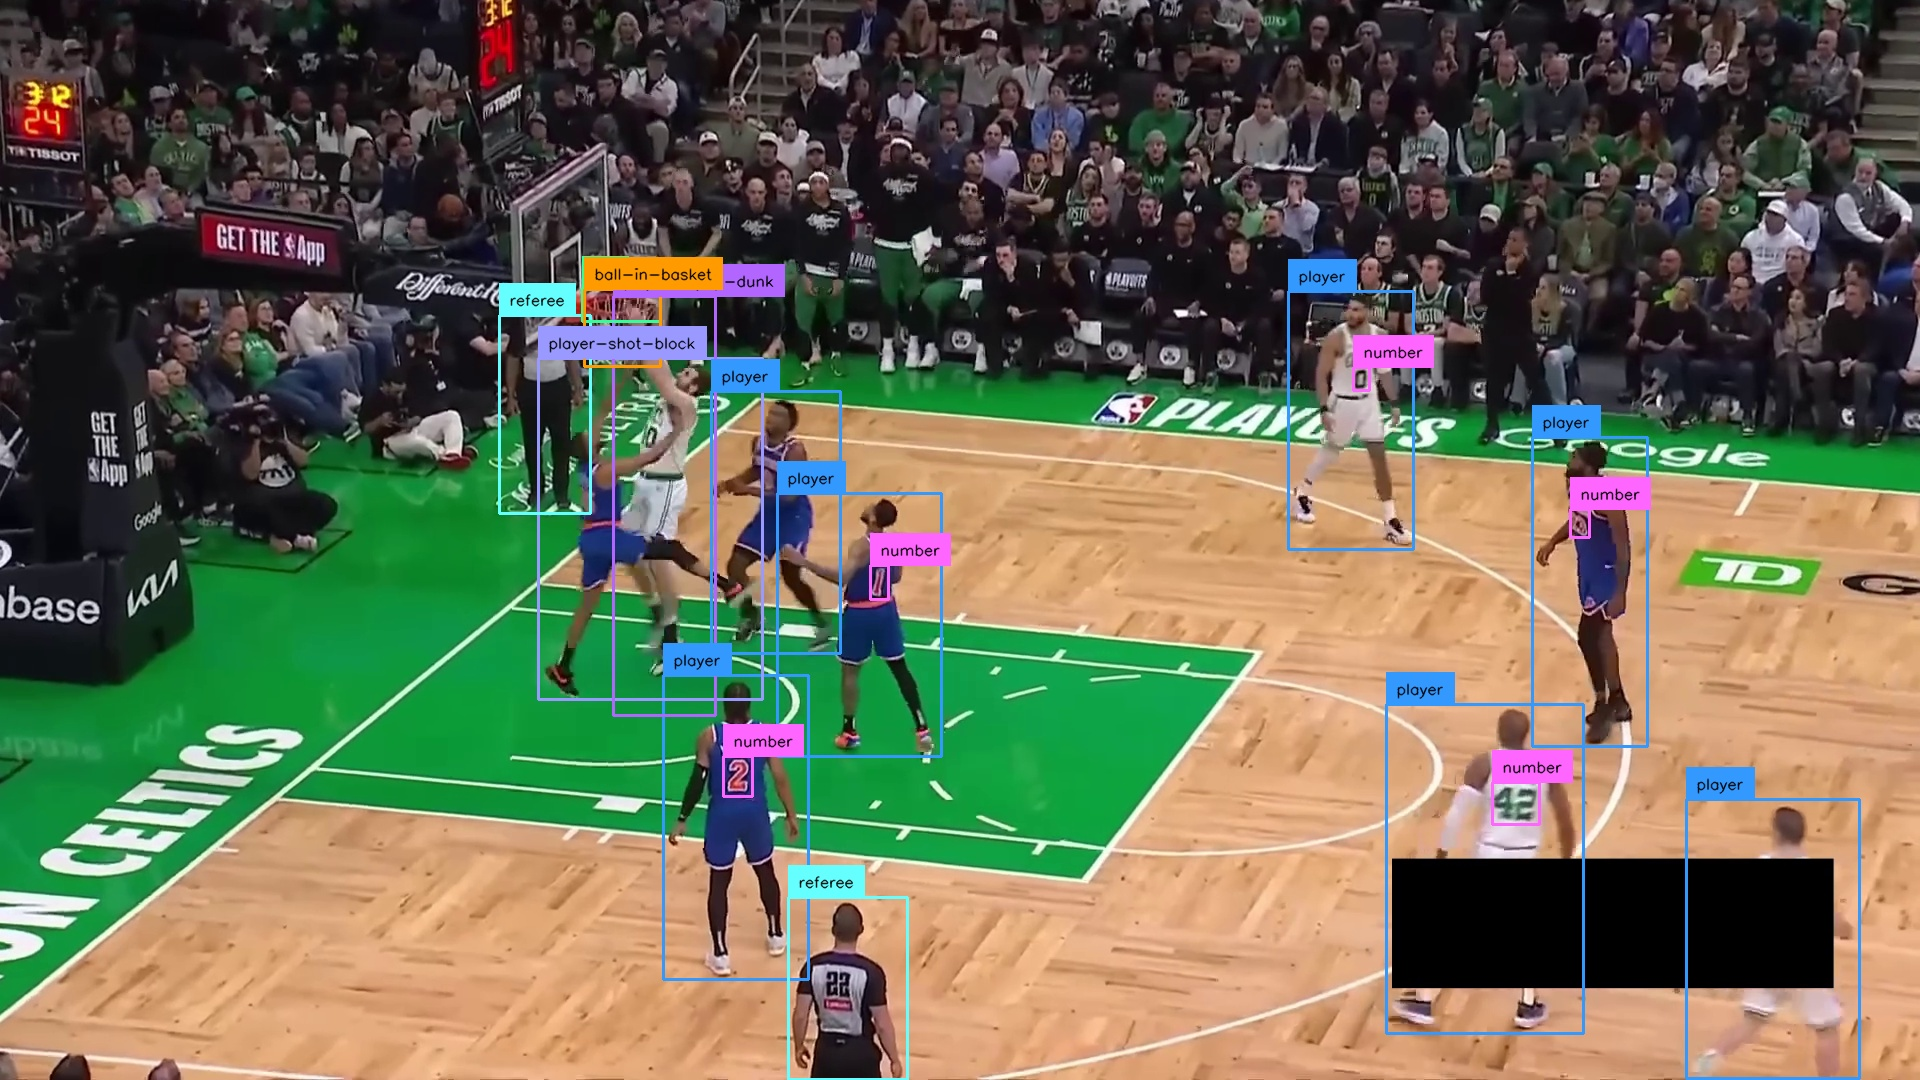

  - manifest: /workspace/api/src/cv/data/video/boston-celtics-new-york-knicks-game-1/boston-celtics-new-york-knicks-game-1-q1-03.16-03.11-markers-smoke_manifest.json

COMPREHENSIVE KEYPOINT DEBUGGING REPORT

1. RAW DETECTION ANALYSIS:
----------------------------------------
✓ Keypoints XY shape: (1, 33, 2)
✓ Confidence shape: (1, 33)

2. CONFIDENCE ANALYSIS:
----------------------------------------
Confidence statistics:
     min: 0.0014
     max: 0.9983
    mean: 0.3648
  median: 0.0196
     std: 0.4621

Threshold analysis (threshold = 0.5):
  Total keypoints: 33
  Above threshold: 12
  Below threshold: 21
  Retention rate: 36.4%

3. SPATIAL ANALYSIS:
----------------------------------------
All keypoints spatial distribution:
  X range: [7.0, 1920.0]
  Y range: [451.0, 1080.0]
  Center: (1041.2, 757.1)
  Spread: (462.4, 189.7)

High-confidence keypoints spatial distribution:
  X range: [318.0, 1613.0]
  Y range: [451.0, 1077.0]
  Center: (929.6, 689.2)

4. FILTERING STAGES:
--------

In [2]:
# %%writefile api/src/cv/shot_pipeline.py
"""
Featureized CV shot pipeline.

Each major step is a small function so you can test or swap components:
- detect_players
- detect_court_keypoints
- compute_transforms
- update_shot_events
- annotate_broadcast_overlay
- render_court_map
- process_video / process_many_videos

A real smoke test runs under `if __name__ == "__main__":` using your config paths.
"""

from __future__ import annotations

from dataclasses import dataclass
from collections import deque
from pathlib import Path
from typing import Optional, Sequence, Tuple, Dict, List

import numpy as np
import supervision as sv

from sports import MeasurementUnit, ViewTransformer
from sports.basketball import (
    CourtConfiguration,
    League,
    draw_made_and_miss_on_court,
    ShotEventTracker,
)

from api.src.cv.config import CVConfig, ensure_dirs, load_models, court_base_image


# Utility to show images if enabled in config

def show_image_if_enabled(
    img: np.ndarray, title: str = "Image", cfg: Optional[CVConfig] = None
):
    if cfg is not None and getattr(cfg, "show_images", False):
        import cv2

        cv2.imshow(title, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


def log(msg: str) -> None:
    print(msg, flush=True)


# Utility to display images in Jupyter/IPython notebook

def display_images_in_notebook(image_paths):
    try:
        from IPython.display import display, Image as IPyImage

        for path in image_paths:
            display(IPyImage(filename=str(path)))
    except ImportError:
        print("[INFO] IPython.display not available. Images will not be shown inline.")

def _extract_torso_hsv(frame_bgr: np.ndarray, xyxy: np.ndarray) -> Tuple[float, float, float]:
    """
    Return median (H,S,V in OpenCV ranges H∈[0,180], S∈[0,255], V∈[0,255])
    from a torso crop (middle band) of the bbox. If crop invalid, return NaNs.
    """
    import cv2
    x1, y1, x2, y2 = map(int, xyxy)
    h, w = frame_bgr.shape[:2]
    x1 = max(0, min(w-1, x1)); x2 = max(0, min(w-1, x2))
    y1 = max(0, min(h-1, y1)); y2 = max(0, min(h-1, y2))
    if x2 <= x1 or y2 <= y1:
        return float("nan"), float("nan"), float("nan")
    bw, bh = x2 - x1, y2 - y1
    # Torso band: 35%..75% vertically, 20%..80% horizontally
    tx1 = x1 + int(0.20 * bw); tx2 = x1 + int(0.80 * bw)
    ty1 = y1 + int(0.35 * bh); ty2 = y1 + int(0.75 * bh)
    tx1 = max(x1, min(x2-1, tx1)); tx2 = max(x1+1, min(x2, tx2))
    ty1 = max(y1, min(y2-1, ty1)); ty2 = max(y1+1, min(y2, ty2))
    if tx2 <= tx1 or ty2 <= ty1:
        return float("nan"), float("nan"), float("nan")
    patch = frame_bgr[ty1:ty2, tx1:tx2]
    if patch.size == 0:
        return float("nan"), float("nan"), float("nan")
    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
    H = float(np.nanmedian(hsv[...,0]))
    S = float(np.nanmedian(hsv[...,1]))
    V = float(np.nanmedian(hsv[...,2]))
    return H, S, V


def _kmeans1d_two_clusters(values: np.ndarray, max_iter: int = 20) -> np.ndarray:
    """
    Simple 1D k-means with k=2 (no sklearn). Returns labels {0,1}.
    Ignores NaNs. If <2 valid values, returns zeros.
    Robust to empty clusters (no 'mean of empty slice' warnings).
    """
    vals = values[~np.isnan(values)]
    if vals.size < 2:
        return np.zeros_like(values, dtype=int)

    # init centers at extremes of valid values
    c0, c1 = float(np.min(vals)), float(np.max(vals))
    labels = np.zeros_like(values, dtype=int)

    def safe_mean(arr: np.ndarray) -> float:
        arr = arr[~np.isnan(arr)]
        return float(np.mean(arr)) if arr.size else float('nan')

    for _ in range(max_iter):
        d0 = np.abs(values - c0)
        d1 = np.abs(values - c1)
        # NaNs stay NaN in distances; prefer cluster 0 for NaNs (they'll be ignored downstream)
        lbl = (d1 < d0).astype(int)
        # recompute centers only from members (ignore NaN members)
        m0 = safe_mean(values[lbl == 0])
        m1 = safe_mean(values[lbl == 1])
        # if any cluster empty, keep its previous center (prevents nanmean warnings)
        new_c0 = c0 if np.isnan(m0) else m0
        new_c1 = c1 if np.isnan(m1) else m1
        if np.allclose([c0, c1], [new_c0, new_c1], atol=1e-3, equal_nan=True):
            labels = lbl
            break
        c0, c1 = new_c0, new_c1
        labels = lbl

    # Stable label order: ensure center0 < center1
    c0_final = safe_mean(values[labels == 0])
    c1_final = safe_mean(values[labels == 1])
    if not np.isnan(c0_final) and not np.isnan(c1_final) and c0_final > c1_final:
        labels = 1 - labels

    print(f"[DEBUG][teams] hue centers ~ [{c0_final:.1f}, {c1_final:.1f}] (OpenCV hue 0..180)")
    return labels



def group_players_into_teams(
    frame_bgr: np.ndarray,
    dets: sv.Detections,
    cfg: CVConfig,
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Split detections into {'A': {...}, 'B': {...}, 'REF': {...}} using:
      - referee by class id or label (if available in dets.data)
      - team clustering by torso hue for non-ref detections (k=2)
    Returns per-group dicts with:
      {'idx': indices, 'xyxy': boxes, 'anchors': bottom-center points}
    """
    N = len(dets)
    if N == 0:
        return {
            "A": {"idx": np.array([], int), "xyxy": np.empty((0,4), float), "anchors": np.empty((0,2), float)},
            "B": {"idx": np.array([], int), "xyxy": np.empty((0,4), float), "anchors": np.empty((0,2), float)},
            "REF": {"idx": np.array([], int), "xyxy": np.empty((0,4), float), "anchors": np.empty((0,2), float)},
        }

    # --- Referees via class id or label ---
    class_names = None
    if hasattr(dets, "data") and isinstance(dets.data, dict) and "class_name" in dets.data:
        class_names = np.array([str(x).lower() for x in dets.data["class_name"]])

    is_ref = np.zeros((N,), dtype=bool)
    if dets.class_id is not None and len(cfg.referee_class_ids) > 0:
        is_ref |= np.isin(dets.class_id, cfg.referee_class_ids)
    if class_names is not None and len(cfg.referee_labels) > 0:
        for token in cfg.referee_labels:
            is_ref |= np.char.find(class_names, token) >= 0

    # --- Team clustering on non-refs ---
    idx_nonref = np.where(~is_ref)[0]
    hues = np.full((N,), np.nan, dtype=float)
    if dets.xyxy is not None and len(idx_nonref) > 0:
        for i in idx_nonref:
            H, S, V = _extract_torso_hsv(frame_bgr, dets.xyxy[i])
            # ignore super-low saturation as unreliable jersey hue
            hues[i] = H if (not np.isnan(S) and S >= 20.0) else np.nan

    labels = np.zeros((N,), dtype=int)
    if len(idx_nonref) >= 2:
        labels[idx_nonref] = _kmeans1d_two_clusters(hues[idx_nonref])
    # If only 0/1 non-refs, they default to team A (label 0)

    # Pack outputs
    def pack(mask: np.ndarray):
        idx = np.where(mask)[0]
        xyxy = dets.xyxy[idx] if dets.xyxy is not None else np.empty((0,4), float)
        anchors = dets[idx].get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
        anchors = np.asarray(anchors, dtype=float) if anchors is not None else np.empty((0,2), float)
        return {"idx": idx.astype(int), "xyxy": np.asarray(xyxy, float), "anchors": anchors}

    A = pack((~is_ref) & (labels == 0))
    B = pack((~is_ref) & (labels == 1))
    R = pack(is_ref)

    print(f"[DEBUG][teams] counts A={len(A['idx'])} B={len(B['idx'])} REF={len(R['idx'])}")
    return {"A": A, "B": B, "REF": R}


def annotate_broadcast_players(
    frame: np.ndarray,
    groups: Dict[str, Dict[str, np.ndarray]],
    cfg: CVConfig,
) -> np.ndarray:
    """
    Draw bottom-center markers for Team A (blue), Team B (orange), Ref (grey).
    """
    out = frame.copy()

    def draw_points(xy: np.ndarray, color: sv.Color, label: str):
        if xy is None or len(xy) == 0:
            return
        pts = detections_from_points(xy)
        tri = sv.TriangleAnnotator(color=color, base=22, height=18, color_lookup=sv.ColorLookup.CLASS)
        text = sv.RichLabelAnnotator(font_size=28, color=color, text_color=sv.Color.WHITE,
                                     color_lookup=sv.ColorLookup.CLASS, text_position=sv.Position.TOP_CENTER)
        lbls = [label] * len(pts)
        nonlocal out
        out = tri.annotate(scene=out, detections=pts)
        out = text.annotate(scene=out, detections=pts, labels=lbls)

    draw_points(groups["A"]["anchors"], cfg.team_a_color, "Team A")
    draw_points(groups["B"]["anchors"], cfg.team_b_color, "Team B")
    draw_points(groups["REF"]["anchors"], cfg.referee_color, "Ref")

    return out

# ------------------------- Data Structures -------------------------


@dataclass
class Shot:
    x: float
    y: float
    distance: float
    result: bool
    team: int


class KeyPointsSmoother:
    def __init__(self, length: int):
        self.length = length
        self.buffer = deque(maxlen=length)
        self._last_valid: Optional[np.ndarray] = None  # (1, m, 2)

    def update(
        self,
        xy: np.ndarray,
        confidence: Optional[np.ndarray] = None,
        conf_threshold: float = 0.0,
    ) -> np.ndarray:
        # Expected (1, m, 2)
        if xy.ndim != 3 or xy.shape[0] != 1:
            raise ValueError(f"Expected shape (1, m, 2); got {xy.shape}")

        # Fast exit: no keypoints
        if xy.shape[1] == 0:
            return xy.astype(np.float32, copy=True)

        xy_f = xy.astype(np.float32, copy=True)

        if confidence is not None:
            if confidence.shape[:2] != xy.shape[:2]:
                raise ValueError(
                    f"confidence shape {confidence.shape} mismatches xy {xy.shape}"
                )
            mask = (confidence >= conf_threshold)[..., None]  # (1, m, 1)
            xy_f = np.where(mask, xy_f, np.nan)

        self.buffer.append(xy_f)
        stacked = np.stack(self.buffer, axis=0)  # (t, 1, m, 2)

        # Entire buffer is NaN?
        if np.isnan(stacked).all():
            return (
                self._last_valid
                if self._last_valid is not None
                else xy.astype(np.float32, copy=True)
            )

        # Compute nanmean but avoid warnings for all-NaN columns
        smoothed = np.nanmean(stacked, axis=0)  # (1, m, 2)

        # Columns that are still NaN in both coords → backfill
        dead_cols = np.isnan(smoothed).all(axis=-1)  # (1, m)
        if dead_cols.any():
            if (
                self._last_valid is not None
                and self._last_valid.shape[1] == smoothed.shape[1]
            ):
                smoothed[dead_cols] = self._last_valid[dead_cols]
            else:
                smoothed[dead_cols] = xy.astype(np.float32, copy=True)[dead_cols]

        if np.isfinite(smoothed).any():
            self._last_valid = smoothed

        return smoothed


# ---------------------------- Utilities ----------------------------


def euclidean_distance(
    start_point: Sequence[float], end_point: Sequence[float]
) -> float:
    s = np.asarray(start_point, dtype=float)
    e = np.asarray(end_point, dtype=float)
    if s.shape != (2,) or e.shape != (2,):
        raise ValueError("Both points must have shape (2,).")
    return float(np.linalg.norm(e - s))


def extract_xy(shots: List[Shot]) -> np.ndarray:
    return np.array([[s.x, s.y] for s in shots], dtype=float)


def extract_class_id(shots: List[Shot]) -> np.ndarray:
    return np.array([s.team for s in shots], dtype=int)


# ------------------------- Feature Functions -----------------------


def detect_players(frame: np.ndarray, player_model, cfg: CVConfig) -> sv.Detections:
    result = player_model.infer(
        frame,
        confidence=cfg.confidence_threshold,
        iou_threshold=cfg.iou_threshold,
    )[0]
    return sv.Detections.from_inference(result)


def detect_court_keypoints(
    frame: np.ndarray, court_model, cfg: CVConfig
) -> sv.KeyPoints:
    result = court_model.infer(frame, confidence=cfg.detection_confidence_court)[0]
    return sv.KeyPoints.from_inference(result)


def _compute_homog_and_quality(
    detected_on_image: np.ndarray,
    court_vertices: np.ndarray,
    cfg: CVConfig,
    *,
    court_rmse_limit: Optional[float] = None,
    image_rmse_limit: Optional[float] = None,
) -> Tuple[bool, Optional[ViewTransformer], Optional[ViewTransformer], Dict]:
    """
    Fit both directions and compute RMSEs. Returns (ok, img2court, court2img, quality_dict).
    ok=True means transforms were constructed; not a pass/fail vs thresholds.
    """
    try:
        img2court = ViewTransformer(source=detected_on_image, target=court_vertices)
        court2img = ViewTransformer(source=court_vertices, target=detected_on_image)
    except Exception as e:
        if getattr(cfg, "debug_level", 0) >= 1:
            print(f"[DEBUG][homography] ViewTransformer fit error: {e}")
        return False, None, None, {}

    # forward reprojection (court units)
    try:
        pred_court = img2court.transform_points(detected_on_image)
        err_court = np.linalg.norm(pred_court - court_vertices, axis=1)
        rmse_court = float(np.sqrt(np.mean(err_court ** 2))) if err_court.size else float("inf")
    except Exception as e:
        if getattr(cfg, "debug_level", 0) >= 1:
            print(f"[DEBUG][homography] forward reprojection error: {e}")
        return False, None, None, {}

    # backward reprojection (image pixels)
    try:
        pred_img = court2img.transform_points(court_vertices)
        err_img = np.linalg.norm(pred_img - detected_on_image, axis=1)
        rmse_img = float(np.sqrt(np.mean(err_img ** 2))) if err_img.size else float("inf")
    except Exception as e:
        if getattr(cfg, "debug_level", 0) >= 1:
            print(f"[DEBUG][homography] backward reprojection error: {e}")
        return False, None, None, {}

    quality = {
        "rmse_court": rmse_court,
        "rmse_image": rmse_img,
        # include per-point diagnostics for callers that want them
        "err_court": err_court.tolist(),
        "err_image": err_img.tolist(),
    }

    return True, img2court, court2img, quality


def _maybe_dump_homog_debug(cfg: CVConfig, stage: str, payload: Dict) -> None:
    """
    Save a compact JSON debug blob if cfg.debug_dump_on_fail is True.
    Uses cfg.debug_dir or falls back to cfg.image_output_dir.
    """
    if not bool(getattr(cfg, "debug_dump_on_fail", False)):
        return
    try:
        out_dir = getattr(cfg, "debug_dir", getattr(cfg, "image_output_dir", None))
        if out_dir is None:
            return
        out_dir.mkdir(parents=True, exist_ok=True)
        path = out_dir / f"homography_debug_{stage}.json"
        import json
        with open(path, "w") as f:
            json.dump(payload, f, indent=2)
        if getattr(cfg, "debug_level", 0) >= 1:
            print(f"[DEBUG][homography] wrote debug → {path}")
    except Exception as e:
        if getattr(cfg, "debug_level", 0) >= 1:
            print(f"[DEBUG][homography] debug dump failed: {e}")


def _get_model_vertices(key_points: sv.KeyPoints, cfg: CVConfig) -> Optional[np.ndarray]:
    """
    Returns canonical court vertices (float32, shape (M,2)) aligned to the model's keypoint index order.
    Priority:
      1) key_points.data['target_xy'] or ['court_xy'] if present (already aligned to indices)
      2) Fallback to cfg.court_config.vertices (length must match number of keypoints M)
    """
    # 1) Prefer explicit mappings from the model, if available
    if hasattr(key_points, "data") and isinstance(key_points.data, dict):
        for k in ("target_xy", "court_xy"):
            if k in key_points.data and key_points.data[k] is not None:
                arr = np.asarray(key_points.data[k], dtype=np.float32)
                if arr.ndim == 2 and arr.shape[1] == 2:
                    return arr

    # 2) Fallback: use the known canonical vertices from court configuration
    verts = np.asarray(cfg.court_config.vertices, dtype=np.float32)
    # We expect one vertex per model index
    if key_points.xy is None or key_points.xy.ndim != 3 or key_points.xy.shape[0] < 1:
        return None
    M = key_points.xy.shape[1]
    if verts.shape[0] != M or verts.shape[1] != 2:
        # Indexing mismatch; better to fail loudly than pair the wrong points
        print(f"[DEBUG][homography] fallback vertices count mismatch: verts={verts.shape} model_kp={M}")
        return None
    return verts


def _dual_ransac_filter(
    img_pts: np.ndarray,        # (k,2), pixels
    court_pts: np.ndarray,      # (k,2), feet
    cfg: CVConfig,
) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """
    Run RANSAC in BOTH directions.
    Keep intersection of inliers to protect quality in both spaces.
    Returns (img_inliers, court_inliers, debug).
    """
    import cv2
    dbg = {
        "used_dual_ransac": True,
        "k_in": int(len(img_pts)),
        "img2court_inliers": None,
        "court2img_inliers": None,
        "k_out": None,
        "reason": None,
        # Add thresholds explicitly so print code never KeyErrors
        "reproj_thresh_ft": float(getattr(cfg, "ransac_reproj_thresh_court_ft", 1.0)),
        "reproj_thresh_px": float(getattr(cfg, "ransac_reproj_thresh_image_px", getattr(cfg, "homography_rmse_image_max", 5.0))),
    }

    k = int(img_pts.shape[0])
    if k < 4:
        dbg["reason"] = "too_few_for_ransac"
        return img_pts, court_pts, dbg

    # Spread check in image space (avoid degenerate clusters)
    spread_x = float(np.max(img_pts[:, 0]) - np.min(img_pts[:, 0]))
    spread_y = float(np.max(img_pts[:, 1]) - np.min(img_pts[:, 1]))
    if spread_x < cfg.min_spread_px or spread_y < cfg.min_spread_px:
        dbg["reason"] = f"degenerate_spread_x={spread_x:.1f}_y={spread_y:.1f}"
        return img_pts, court_pts, dbg

    # --- img -> court (threshold in FEET)
    thr_ft = dbg["reproj_thresh_ft"]
    H_ic, in_ic = cv2.findHomography(img_pts, court_pts, method=cv2.RANSAC,
                                     ransacReprojThreshold=thr_ft, maxIters=2000, confidence=0.995)
    if H_ic is None or in_ic is None:
        dbg["reason"] = "ransac_img2court_failed"
        return img_pts, court_pts, dbg
    in_ic = in_ic.ravel().astype(bool)
    dbg["img2court_inliers"] = in_ic.tolist()

    # --- court -> img (threshold in PIXELS)
    thr_px = dbg["reproj_thresh_px"]
    H_ci, in_ci = cv2.findHomography(court_pts, img_pts, method=cv2.RANSAC,
                                     ransacReprojThreshold=thr_px, maxIters=2000, confidence=0.995)
    if H_ci is None or in_ci is None:
        dbg["reason"] = "ransac_court2img_failed"
        return img_pts, court_pts, dbg
    in_ci = in_ci.ravel().astype(bool)
    dbg["court2img_inliers"] = in_ci.tolist()

    # Intersection of inliers
    inliers = in_ic & in_ci
    num_inliers = int(np.count_nonzero(inliers))
    dbg["k_out"] = num_inliers

    if num_inliers < cfg.min_keypoints_required or num_inliers < int(cfg.min_inlier_ratio * k):
        dbg["reason"] = f"insufficient_intersection_inliers_{num_inliers}_of_{k}"
        return img_pts, court_pts, dbg

    return img_pts[inliers], court_pts[inliers], dbg


def _robust_filter_correspondences(
    detected_on_image: np.ndarray,  # (k,2) float32 pixels
    court_vertices: np.ndarray,     # (k,2) float32 feet
    cfg: CVConfig,
) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """
    Robust outlier pruning. Prefer dual-direction RANSAC when enabled.
    Falls back to single-direction behavior if disabled or if dual fails.
    """
    dbg = {
        "used_ransac": False,
        "k_in": int(len(detected_on_image)),
        "k_out": None,
        # Pre-provide the thresholds so printing is safe
        "reproj_thresh_ft": float(getattr(cfg, "ransac_reproj_thresh_court_ft", 1.0)),
        "reproj_thresh_px": float(getattr(cfg, "ransac_reproj_thresh_image_px", getattr(cfg, "homography_rmse_image_max", 5.0))),
    }

    if int(detected_on_image.shape[0]) < 4:
        dbg["reason"] = "too_few_for_ransac"
        return detected_on_image, court_vertices, dbg

    if getattr(cfg, "enable_robust_homography", True):
        img_in, court_in, dual_dbg = _dual_ransac_filter(detected_on_image, court_vertices, cfg)
        dbg.update(dual_dbg)
        if dual_dbg.get("k_out") is not None and dual_dbg["k_out"] >= cfg.min_keypoints_required:
            dbg["used_ransac"] = True
            return img_in, court_in, dbg
        # Note why dual failed, then try single-direction
        dbg["dual_ransac_failed_reason"] = dual_dbg.get("reason", "unknown")

    # --- Fallback single-direction (img->court). Threshold is in FEET.
    import cv2
    spread_x = float(np.max(detected_on_image[:, 0]) - np.min(detected_on_image[:, 0]))
    spread_y = float(np.max(detected_on_image[:, 1]) - np.min(detected_on_image[:, 1]))
    if spread_x < cfg.min_spread_px or spread_y < cfg.min_spread_px:
        dbg["reason"] = f"degenerate_spread_x={spread_x:.1f}_y={spread_y:.1f}"
        return detected_on_image, court_vertices, dbg

    thr_ft = dbg["reproj_thresh_ft"]
    H, inlier_mask = cv2.findHomography(
        detected_on_image, court_vertices,
        method=cv2.RANSAC, ransacReprojThreshold=thr_ft, maxIters=2000, confidence=0.995
    )
    if H is None or inlier_mask is None:
        dbg["reason"] = "ransac_failed"
        return detected_on_image, court_vertices, dbg

    inlier_mask = inlier_mask.ravel().astype(bool)
    num_inliers = int(np.count_nonzero(inlier_mask))
    dbg.update({
        "used_ransac": True,
        "inliers": inlier_mask.tolist(),
        "k_out": num_inliers,
    })
    if num_inliers < cfg.min_keypoints_required or num_inliers < int(cfg.min_inlier_ratio * len(detected_on_image)):
        dbg["reason"] = f"insufficient_inliers_{num_inliers}_of_{len(detected_on_image)}"
        return detected_on_image, court_vertices, dbg

    return detected_on_image[inlier_mask], court_vertices[inlier_mask], dbg


def compute_transforms(
    key_points: sv.KeyPoints, cfg: CVConfig
) -> Tuple[bool, Optional[ViewTransformer], Optional[ViewTransformer]]:
    """
    Build image<->court transformers using confident keypoints only.
    Steps:
      1) Confidence filter
      2) Vertex pairing (model data or court_config fallback)
      3) Robust outlier pruning (dual-direction RANSAC)
      4) Fit ViewTransformers + compute quality (RMSE in court(ft) and image(px))
      5) If quality passes, also compute and PRINT true 3x3 homographies H(img->court) and H^-1(court->img)
         using least-squares (no RANSAC) on the *accepted inliers* so values are not "fake".
    Returns:
      (ok, img2court, court2img)
    """
    import cv2

    kp_conf = key_points.confidence
    kp_xy = key_points.xy

    if kp_conf is None:
        print("[DEBUG][homography] key_points.confidence is None")
        return False, None, None
    if kp_xy is None or kp_xy.ndim != 3 or kp_xy.shape[0] < 1 or kp_xy.shape[2] != 2:
        print(f"[DEBUG][homography] unexpected key_points.xy shape: {None if kp_xy is None else kp_xy.shape}")
        return False, None, None

    thr = float(getattr(cfg, "keypoint_conf_threshold", 0.50))
    mask = kp_conf[0] > thr
    kept = int(mask.sum())
    total = int(kp_conf.shape[1])
    min_req = int(getattr(cfg, "min_keypoints_required", 4))

    print(f"[DEBUG][homography] conf_filter: kept={kept}/{total} (thr={thr:.2f}; min_req={min_req})")
    if kept < min_req:
        print("[DEBUG][homography] not enough confident keypoints after thresholding")
        return False, None, None

    # Pair to court vertices (model mapping or fallback)
    verts = _get_model_vertices(key_points, cfg)
    if verts is None:
        print("[DEBUG][homography] no court vertices mapping available (model data + fallback both unavailable)")
        return False, None, None

    img_pts_all = kp_xy[0, :, :].astype(np.float32)
    court_pts_all = np.asarray(verts, dtype=np.float32)
    if court_pts_all.shape[0] != kp_xy.shape[1] or court_pts_all.shape[1] != 2:
        print(f"[DEBUG][homography] unexpected court vertices shape: {court_pts_all.shape}")
        return False, None, None

    img_pts = img_pts_all[mask, :]
    court_pts = court_pts_all[mask, :]

    # Robust pruning (dual RANSAC preferred)
    img_in, court_in, rdbg = _robust_filter_correspondences(img_pts, court_pts, cfg)
    spread_x = (np.ptp(img_in[:, 0]) if len(img_in) else 0.0)
    spread_y = (np.ptp(img_in[:, 1]) if len(img_in) else 0.0)
    print(
        "[DEBUG][homography][ransac] "
        f"inliers={len(img_in)}/{len(img_pts)} "
        f"spread=({spread_x:.1f},{spread_y:.1f}) "
        f"dual={rdbg.get('used_dual_ransac', False)} "
        f"thr_ft={rdbg.get('reproj_thresh_ft','?')} thr_px={rdbg.get('reproj_thresh_px','?')} "
        f"reason={rdbg.get('reason', 'ok')}"
    )

    if len(img_in) < min_req:
        print("[DEBUG][homography] not enough inliers after robust filtering")
        return False, None, None

    # Fit both directions and compute quality
    ok, img2court, court2img, quality = _compute_homog_and_quality(
        detected_on_image=img_in, court_vertices=court_in, cfg=cfg,
    )
    if not ok:
        print("[DEBUG][homography] ViewTransformer construction failed")
        return False, None, None

    rmse_court = quality["rmse_court"]
    rmse_img   = quality["rmse_image"]
    print(
        "[DEBUG][homography] "
        f"pairs_used={len(img_in)}/{len(img_pts)} "
        f"RMSE court={rmse_court:.3f}ft  image={rmse_img:.2f}px "
        f"(limits: {cfg.homography_rmse_court_max:.3f}ft/{cfg.homography_rmse_image_max:.2f}px)"
    )

    # Gate checks, with detailed offenders in image space if needed
    court_ok = rmse_court <= cfg.homography_rmse_court_max
    image_ok = rmse_img   <= cfg.homography_rmse_image_max
    if not (court_ok and image_ok):
        errs_img = np.array(quality["err_image"])
        worst_idx = np.argsort(-errs_img)[: min(10, len(errs_img))]
        print("[DEBUG][homography] no valid transform available yet")
        if len(worst_idx):
            print("[DEBUG][homography] worst per-point image errors (px):")
            for wi in worst_idx:
                print(f"   #{wi:02d} -> {errs_img[wi]:6.2f}px")
        return False, None, None

    # ----- NEW: print the TRUE 3x3 homography matrices on the accepted inliers -----
    # Use least-squares on the *accepted* correspondences, no RANSAC here (no fake values).
    H_ic, _ = cv2.findHomography(img_in, court_in, method=0)  # DLT / least-squares
    if H_ic is not None:
        try:
            H_ci = np.linalg.inv(H_ic)
        except np.linalg.LinAlgError:
            H_ci = None
    else:
        H_ci = None

    def _fmt(H: Optional[np.ndarray]) -> str:
        if H is None:
            return "None"
        return "\n".join(
            "    [" + "  ".join(f"{v: .6f}" for v in row) + "]"
            for row in H
        )

    print("[DEBUG][homography][matrix] H(img→court):\n" + _fmt(H_ic))
    print("[DEBUG][homography][matrix] H^-1(court→img):\n" + _fmt(H_ci))

    return True, img2court, court2img




def update_shot_events(
    frame_index: int,
    detections: sv.Detections,
    tracker: ShotEventTracker,
    cfg: CVConfig,
) -> List[Dict]:
    has_jump_shot = len(detections[detections.class_id == cfg.JUMP_SHOT_CLASS_ID]) > 0
    has_layup_dunk = len(detections[detections.class_id == cfg.LAYUP_DUNK_CLASS_ID]) > 0
    has_ball_in_basket = (
        len(detections[detections.class_id == cfg.BALL_IN_BASKET_CLASS_ID]) > 0
    )

    return tracker.update(
        frame_index=frame_index,
        has_jump_shot=has_jump_shot,
        has_layup_dunk=has_layup_dunk,
        has_ball_in_basket=has_ball_in_basket,
    )


def annotate_broadcast_overlay(
    frame: np.ndarray,
    shots: List[Shot],
    court_to_image: Optional[ViewTransformer],
    cfg: CVConfig,
    box_annotator: sv.BoxAnnotator,
    label_annotator: sv.LabelAnnotator,
) -> np.ndarray:
    annotated = frame.copy()
    if court_to_image is None or not shots:
        return annotated

    # Build triangular markers + labels for made & missed
    made_shots = [s for s in shots if s.result]
    missed_shots = [s for s in shots if not s.result]

    # GREEN made
    triangle_annotator = sv.TriangleAnnotator(
        color=sv.Color.from_hex("#007A33"),
        base=25,
        height=21,
        color_lookup=sv.ColorLookup.CLASS,
    )
    text_annotator = sv.RichLabelAnnotator(
        font_size=60,
        color=sv.Color.from_hex("#007A33"),
        text_color=sv.Color.WHITE,
        color_lookup=sv.ColorLookup.CLASS,
        text_position=sv.Position.TOP_CENTER,
    )

    # RED missed
    triangle_missed = sv.TriangleAnnotator(
        color=sv.Color.from_hex("#850101"),
        base=25,
        height=21,
        color_lookup=sv.ColorLookup.CLASS,
    )
    text_missed = sv.RichLabelAnnotator(
        font_size=60,
        color=sv.Color.from_hex("#850101"),
        text_color=sv.Color.WHITE,
        color_lookup=sv.ColorLookup.CLASS,
        text_position=sv.Position.TOP_CENTER,
    )

    if made_shots:
        made_xy_court = extract_xy(made_shots)
        made_xy_img = court_to_image.transform_points(made_xy_court)
        boxes_xyxy = sv.pad_boxes(np.hstack((made_xy_img, made_xy_img)), px=1, py=1)
        classes = extract_class_id(made_shots)
        dets = sv.Detections(xyxy=boxes_xyxy, class_id=classes)
        labels = [f"{int(s.distance)} feet" for s in made_shots]
        annotated = triangle_annotator.annotate(scene=annotated, detections=dets)
        annotated = text_annotator.annotate(
            scene=annotated, detections=dets, labels=labels
        )

    if missed_shots:
        miss_xy_court = extract_xy(missed_shots)
        miss_xy_img = court_to_image.transform_points(miss_xy_court)
        boxes_xyxy = sv.pad_boxes(np.hstack((miss_xy_img, miss_xy_img)), px=1, py=1)
        classes = extract_class_id(missed_shots)
        dets = sv.Detections(xyxy=boxes_xyxy, class_id=classes)
        labels = ["missed"] * len(missed_shots)
        annotated = triangle_missed.annotate(scene=annotated, detections=dets)
        annotated = text_missed.annotate(
            scene=annotated, detections=dets, labels=labels
        )

    return annotated


def render_court_map(
    shots: List[Shot],
    court_base: np.ndarray,
    cfg: CVConfig,
    *,
    teamA_xy: Optional[np.ndarray] = None,
    teamB_xy: Optional[np.ndarray] = None,
    ref_xy: Optional[np.ndarray] = None,
) -> np.ndarray:
    """
    Draw:
      - Team A (blue), Team B (orange), Ref (grey) current positions each frame
      - Accumulated shots (green/red) on top
    We iterate calls to draw_made_and_miss_on_court to emulate multiple "attempt" layers
    (older versions only accept one attempt layer; we fall back to 'miss' color).
    """
    def _layer_attempt(court_img, pts: Optional[np.ndarray], color: sv.Color) -> np.ndarray:
        if pts is None or len(pts) == 0:
            return court_img
        import inspect
        params = set(inspect.signature(draw_made_and_miss_on_court).parameters.keys())
        if "attempt_xy" in params:
            return draw_made_and_miss_on_court(
                config=cfg.court_config,
                court=court_img,
                attempt_xy=np.asarray(pts, float),
                attempt_size=22,
                attempt_color=color,
                attempt_thickness=5,
                scale=cfg.court_scale,
                padding=cfg.court_padding,
                line_thickness=cfg.court_line_thickness,
            )
        # Fallback: use miss layer as a colored dot
        return draw_made_and_miss_on_court(
            config=cfg.court_config,
            court=court_img,
            miss_xy=np.asarray(pts, float),
            miss_size=22,
            miss_color=color,
            miss_thickness=5,
            scale=cfg.court_scale,
            padding=cfg.court_padding,
            line_thickness=cfg.court_line_thickness,
        )

    made_xy = np.array([(s.x, s.y) for s in shots if s.result], dtype=float)
    miss_xy = np.array([(s.x, s.y) for s in shots if not s.result], dtype=float)

    # base court
    img = court_base.copy()

    # teams + refs (current frame positions)
    img = _layer_attempt(img, teamA_xy, cfg.team_a_color)
    img = _layer_attempt(img, teamB_xy, cfg.team_b_color)
    img = _layer_attempt(img, ref_xy,  cfg.referee_color)

    # shots on top for visibility
    img = draw_made_and_miss_on_court(
        config=cfg.court_config,
        court=img,
        made_xy=made_xy if len(made_xy) else None,
        miss_xy=miss_xy if len(miss_xy) else None,
        made_size=25,
        miss_size=25,
        made_color=cfg.made_color,
        miss_color=cfg.miss_color,
        made_thickness=6,
        miss_thickness=6,
        scale=cfg.court_scale,
        padding=cfg.court_padding,
        line_thickness=cfg.court_line_thickness,
    )
    return img



# ---------------------------- Main Loop ----------------------------
import cv2, json, shutil, subprocess


def _save_image(path: Path, img: np.ndarray, *, colorspace: str = "bgr") -> bool:
    """
    Save an image to disk. Returns True on success, False otherwise.

    colorspace:
      - "bgr": img is OpenCV/BGR; write as-is.
      - "rgb": img is RGB; convert to BGR for cv2.imwrite.
      - "gray": single-channel; write as-is.
    """
    path.parent.mkdir(parents=True, exist_ok=True)
    try:
        import cv2
        if img.ndim == 2 or colorspace.lower() == "gray":
            ok = cv2.imwrite(str(path), img)
        elif colorspace.lower() == "bgr":
            ok = cv2.imwrite(str(path), img)
        elif colorspace.lower() == "rgb":
            bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            ok = cv2.imwrite(str(path), bgr)
        else:
            # Be explicit; don't guess silently.
            raise ValueError(f"Unsupported colorspace '{colorspace}'. Use 'bgr'|'rgb'|'gray'.")
        if not ok:
            print(f"[DEBUG] cv2.imwrite returned False for {path}")
        return ok
    except Exception as e:
        print(f"[DEBUG] Failed to save image {path}: {e}")
        return False



def _get_frame_at(video_path: Path, frame_index: int) -> Optional[np.ndarray]:
    """Robust frame grab: clamp to valid range and fallback to frame 0."""
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        log(f"[DEBUG] cannot open video: {video_path}")
        return None

    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    # Clamp to valid index if total is known; else try requested index directly
    idx = frame_index
    if total > 0:
        idx = max(0, min(frame_index, total - 1))
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ok, frame = cap.read()
    cap.release()

    if ok and frame is not None:
        return frame

    # Fallback: try the very first frame
    cap = cv2.VideoCapture(str(video_path))
    ok, frame = cap.read()
    cap.release()
    if ok and frame is not None:
        log(f"[DEBUG] seek to frame {frame_index} failed; used frame 0 instead")
        return frame

    log(f"[DEBUG] failed to read any frame from {video_path}")
    return None


def _write_placeholder(
    video_path: Path, suffix: str, reason: str, base_img: Optional[np.ndarray] = None
) -> Path:
    """
    Create a simple placeholder image (gray or based on a provided frame) with a stamped reason.
    Always returns a path.
    """
    out = video_path.parent / f"{video_path.stem}-{suffix}.jpg"
    try:
        if base_img is None:
            # Make a small gray canvas
            img = np.full((320, 640, 3), 180, dtype=np.uint8)
        else:
            img = base_img.copy()
            if img.ndim == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Stamp reason
        cv2.rectangle(img, (0, 0), (img.shape[1], 40), (50, 50, 50), -1)
        cv2.putText(
            img,
            reason,
            (10, 28),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (255, 255, 255),
            2,
            cv2.LINE_AA,
        )

        _save_image(out, img)
        log(f"[SMOKE] wrote placeholder: {out} ({reason})")
    except Exception as e:
        log(f"[DEBUG] placeholder write failed for {out}: {e}")
    return out


def save_stage_all_detections(
    video_path: Path, cfg: CVConfig, player_model
) -> Optional[Path]:
    frame = _get_frame_at(video_path, cfg.start_frame_index)
    if frame is None:
        return _write_placeholder(video_path, "stage_all_detections", "NO FRAME")

    result = player_model.infer(frame, confidence=cfg.confidence_threshold)[0]
    dets = sv.Detections.from_inference(result)

    img = sv.BoxAnnotator(color=cfg.palette, thickness=2).annotate(
        scene=frame.copy(), detections=dets
    )
    img = sv.LabelAnnotator(color=cfg.palette, text_color=sv.Color.BLACK).annotate(
        scene=img, detections=dets
    )
    show_image_if_enabled(img, "Stage All Detections", cfg)
    out = video_path.parent / f"{video_path.stem}-stage_all_detections.jpg"
    if _save_image(out, img):
        log(f"[SMOKE] stage_all_detections: {out}")
        return out
    return _write_placeholder(
        video_path, "stage_all_detections", "IMWRITE FAILED", base_img=frame
    )


def detections_from_points(xy: np.ndarray) -> sv.Detections:
    """
    Convert an array of (x,y) points into tiny 2x2 boxes so Supervision annotators
    can place markers (triangles/text) exactly at those points, like the notebook.
    """
    if xy is None or len(xy) == 0:
        return sv.Detections(
            xyxy=np.empty((0, 4), dtype=float), class_id=np.array([], dtype=int)
        )
    xyxy = sv.pad_boxes(np.hstack([xy, xy]), px=1, py=1)  # (n,4)
    return sv.Detections(xyxy=xyxy, class_id=np.zeros((xyxy.shape[0],), dtype=int))


def save_stage_jump_shots(
    video_path: Path, cfg: CVConfig, player_model
) -> Optional[Path]:
    frame = _get_frame_at(video_path, cfg.start_frame_index)
    if frame is None:
        return _write_placeholder(video_path, "stage_jump_shots", "NO FRAME")

    result = player_model.infer(frame, confidence=cfg.confidence_threshold)[0]
    dets_all = sv.Detections.from_inference(result)
    dets = dets_all[dets_all.class_id == cfg.JUMP_SHOT_CLASS_ID]

    anchors_xy = dets.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
    dets_points = detections_from_points(anchors_xy)

    green = sv.Color.from_hex("#007A33")
    triangle = sv.TriangleAnnotator(
        color=green, base=25, height=21, color_lookup=sv.ColorLookup.INDEX
    )
    text = sv.RichLabelAnnotator(
        font_size=60,
        color=green,
        text_color=sv.Color.WHITE,
        color_lookup=sv.ColorLookup.INDEX,
        text_position=sv.Position.TOP_CENTER,
    )

    img = frame.copy()
    if len(dets_points) > 0:
        img = triangle.annotate(scene=img, detections=dets_points)
        labels = ["here"] * len(dets_points)
        img = text.annotate(scene=img, detections=dets_points, labels=labels)
    else:
        cv2.putText(
            img,
            "NO JUMP-SHOT DETECTIONS",
            (10, 40),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            (0, 0, 255),
            2,
            cv2.LINE_AA,
        )
    show_image_if_enabled(img, "Stage Jump Shots", cfg)
    out = video_path.parent / f"{video_path.stem}-stage_jump_shots.jpg"
    if _save_image(out, img):
        log(f"[SMOKE] stage_jump_shots: {out}")
        return out
    return _write_placeholder(
        video_path, "stage_jump_shots", "IMWRITE FAILED", base_img=frame
    )


def save_stage_keypoints(
    video_path: Path, cfg: CVConfig, court_model
) -> Optional[Path]:
    frame = _get_frame_at(video_path, cfg.start_frame_index)
    if frame is None:
        return _write_placeholder(video_path, "stage_keypoints", "NO FRAME")

    result = court_model.infer(frame, confidence=cfg.detection_confidence_court)[0]
    kps_all = sv.KeyPoints.from_inference(result)

    img = frame.copy()
    reason = None
    if (kps_all.confidence is None) or (kps_all.xy.shape[1] == 0):
        reason = "NO KEYPOINTS/CONFIDENCE"
    else:
        mask = kps_all.confidence[0] >= cfg.keypoint_conf_threshold
        xy_all = kps_all.xy[0]; conf_all = kps_all.confidence[0]
        # draw all with tiny index to verify ordering
        for i, (x, y) in enumerate(xy_all):
            cv2.circle(img, (int(x), int(y)), 5, (255, 20, 147), thickness=-1)  # magenta dot
            cv2.putText(img, str(i), (int(x)+6, int(y)-6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(img, f"{conf_all[i]:.2f}", (int(x)+6, int(y)+12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (50,255,50) if mask[i] else (60,60,60), 1, cv2.LINE_AA)

        if np.count_nonzero(mask) < cfg.min_keypoints_required:
            reason = f"< {cfg.min_keypoints_required} CONFIDENT KP"

    if reason:
        cv2.putText(img, reason, (10, 40), cv2.FONT_HERSHEY_SIMPLEX,
                    1.0, (0, 0, 255), 2, cv2.LINE_AA)

    show_image_if_enabled(img, "Stage Keypoints", cfg)
    out = video_path.parent / f"{video_path.stem}-stage_keypoints.jpg"
    if _save_image(out, img):
        log(f"[SMOKE] stage_keypoints: {out}")
        return out
    return _write_placeholder(video_path, "stage_keypoints", "IMWRITE FAILED", base_img=frame)



def save_stage_mark_on_court(
    video_path: Path, cfg: CVConfig, player_model, court_model
) -> Optional[Path]:
    """
    Uses the SAME robust homography pipeline as compute_transforms.
    Marks detected shot anchors on the overhead 2D court image.
    """
    frame = _get_frame_at(video_path, cfg.start_frame_index)
    if frame is None:
        return _write_placeholder(video_path, "stage_mark_on_court", "NO FRAME")

    # Detect court keypoints
    court_result = court_model.infer(frame, confidence=cfg.detection_confidence_court)[0]
    kps = sv.KeyPoints.from_inference(court_result)
    if kps.confidence is None or kps.xy is None or kps.xy.shape[1] == 0:
        return _write_placeholder(video_path, "stage_mark_on_court", "NO KEYPOINTS", base_img=frame)

    # Build transforms with robust filtering + RMSE gating
    ok, img2court, _court2img = compute_transforms(kps, cfg)
    if not ok or img2court is None:
        return _write_placeholder(video_path, "stage_mark_on_court", "HOMOGRAPHY FAIL", base_img=frame)

    # Detect players and collect candidate shot anchors (jump-shots and layup/dunks)
    result = player_model.infer(frame, confidence=cfg.confidence_threshold)[0]
    dets = sv.Detections.from_inference(result)
    shot_mask = (dets.class_id == cfg.JUMP_SHOT_CLASS_ID) | (dets.class_id == cfg.LAYUP_DUNK_CLASS_ID)
    anchors_img = dets[shot_mask].get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
    if anchors_img is None or len(anchors_img) == 0:
        return _write_placeholder(video_path, "stage_mark_on_court", "NO JUMP-SHOT ANCHOR", base_img=frame)

    # Map to court coordinates via the vetted transform
    anchors_court = img2court.transform_points(points=np.asarray(anchors_img, dtype=float))

    # Draw on court and save
    court_img = draw_made_and_miss_on_court(
        config=cfg.court_config,
        made_xy=anchors_court,
        made_size=25,
        made_color=sv.Color.from_hex("#007A33"),
        made_thickness=6,
        line_thickness=4,
        scale=cfg.court_scale,
        padding=cfg.court_padding,
    )
    show_image_if_enabled(court_img, "Stage Mark On Court", cfg)
    out = video_path.parent / f"{video_path.stem}-stage_mark_on_court.jpg"
    if _save_image(out, court_img):
        log(f"[SMOKE] stage_mark_on_court: {out}")
        return out
    return _write_placeholder(video_path, "stage_mark_on_court", "IMWRITE FAILED", base_img=frame)



def save_stage_homography(
    video_path: Path, cfg: CVConfig, player_model, court_model
) -> Dict[str, Optional[Path]]:
    """
    Writes:
      1) A broadcast-frame overlay of a court grid projected via court->image transform
         (…-stage_homography_grid.jpg)
      2) A 2D court image with team/ref positions mapped via image->court
         (…-stage_court_players.jpg)
      3) A JSON file with the matrices and RMSE (…-stage_homography.json)

    Returns dict of saved paths (or None if a placeholder was emitted).
    """
    import json

    out = {"grid_overlay": None, "court_players": None, "json": None}

    frame = _get_frame_at(video_path, cfg.start_frame_index)
    if frame is None:
        _write_placeholder(video_path, "stage_homography", "NO FRAME")
        return out

    # --- Detect court keypoints & build transforms ---
    court_result = court_model.infer(frame, confidence=cfg.detection_confidence_court)[0]
    kps = sv.KeyPoints.from_inference(court_result)
    ok, img2court, court2img = compute_transforms(kps, cfg)
    if not ok or img2court is None or court2img is None:
        _write_placeholder(video_path, "stage_homography", "HOMOGRAPHY FAIL", base_img=frame)
        return out

    # --- 1) Court GRID over broadcast frame (visual check for alignment) ---
    # Build a coarse grid in court space (ft) and project to image to draw.
    h_img, w_img = frame.shape[:2]
    overlay = frame.copy()
    # NBA ~ 94 (length) x 50 (width) feet; the CourtConfiguration matches this coordinate system.
    # Use the config vertices to get extents (safer than hardcoding).
    verts = np.asarray(cfg.court_config.vertices, dtype=float)
    minx, maxx = float(np.min(verts[:, 0])), float(np.max(verts[:, 0]))
    miny, maxy = float(np.min(verts[:, 1])), float(np.max(verts[:, 1]))
    xs = np.linspace(minx, maxx, 11)  # 10 stripes
    ys = np.linspace(miny, maxy, 21)  # finer along length

    # Horizontal lines (y fixed)
    for y in ys:
        pts_court = np.column_stack([xs, np.full_like(xs, y)])
        pts_img = court2img.transform_points(pts_court)
        pts_img = np.asarray(pts_img, dtype=float)
        for i in range(len(pts_img) - 1):
            p1 = tuple(np.clip(np.round(pts_img[i]).astype(int), [0, 0], [w_img - 1, h_img - 1]))
            p2 = tuple(np.clip(np.round(pts_img[i + 1]).astype(int), [0, 0], [w_img - 1, h_img - 1]))
            cv2.line(overlay, p1, p2, (0, 255, 255), 1, cv2.LINE_AA)  # yellow lines

    # Vertical lines (x fixed)
    for x in xs:
        pts_court = np.column_stack([np.full_like(ys, x), ys])
        pts_img = court2img.transform_points(pts_court)
        pts_img = np.asarray(pts_img, dtype=float)
        for i in range(len(pts_img) - 1):
            p1 = tuple(np.clip(np.round(pts_img[i]).astype(int), [0, 0], [w_img - 1, h_img - 1]))
            p2 = tuple(np.clip(np.round(pts_img[i + 1]).astype(int), [0, 0], [w_img - 1, h_img - 1]))
            cv2.line(overlay, p1, p2, (0, 255, 255), 1, cv2.LINE_AA)

    grid_path = video_path.parent / f"{video_path.stem}-stage_homography_grid.jpg"
    if _save_image(grid_path, overlay):
        log(f"[SMOKE] stage_homography_grid: {grid_path}")
        out["grid_overlay"] = grid_path

    # --- 2) Court map with team/ref positions (same as your earlier visual) ---
    result = player_model.infer(frame, confidence=cfg.confidence_threshold)[0]
    dets = sv.Detections.from_inference(result)
    groups = group_players_into_teams(frame, dets, cfg)
    teamA_img = groups["A"]["anchors"]
    teamB_img = groups["B"]["anchors"]
    ref_img   = groups["REF"]["anchors"]

    # Transform anchors to court space
    teamA_court = img2court.transform_points(teamA_img) if teamA_img is not None and len(teamA_img) else None
    teamB_court = img2court.transform_points(teamB_img) if teamB_img is not None and len(teamB_img) else None
    ref_court   = img2court.transform_points(ref_img)   if ref_img   is not None and len(ref_img)   else None

    court_img = render_court_map(
        shots=[],  # no shots in this stage; it's a pose sanity-check
        court_base=court_base_image(cfg),
        cfg=cfg,
        teamA_xy=teamA_court,
        teamB_xy=teamB_court,
        ref_xy=ref_court,
    )
    court_players_path = video_path.parent / f"{video_path.stem}-stage_court_players.jpg"
    if _save_image(court_players_path, court_img):
        log(f"[SMOKE] stage_court_players: {court_players_path}")
        out["court_players"] = court_players_path

    # --- 3) Persist homography numbers (matrix, RMSE, counts) as JSON ---
    # Reproduce the inliers from the call so values match logs (no fabricated fields).
    kp_conf = kps.confidence
    kp_xy   = kps.xy
    thr = float(getattr(cfg, "keypoint_conf_threshold", 0.50))
    mask = kp_conf[0] > thr

    verts_model = _get_model_vertices(kps, cfg)
    img_pts = kp_xy[0, mask, :].astype(np.float32)
    court_pts = np.asarray(verts_model, dtype=np.float32)[mask, :]

    # Apply the same robust filter again to recover the used inliers for JSON
    img_in, court_in, _ = _robust_filter_correspondences(img_pts, court_pts, cfg)
    H_ic, _ = cv2.findHomography(img_in, court_in, method=0)
    H_ci = None
    if H_ic is not None:
        try:
            H_ci = np.linalg.inv(H_ic)
        except np.linalg.LinAlgError:
            pass

    # RMSE values are exactly what compute_transforms printed last
    # (we can't pull them out directly, so re-evaluate using the fitted ViewTransformers)
    pred_court = img2court.transform_points(img_in)
    rmse_ft = float(np.sqrt(np.mean(np.sum((pred_court - court_in) ** 2, axis=1)))) if len(img_in) else float("inf")
    pred_img = court2img.transform_points(court_in)
    rmse_px = float(np.sqrt(np.mean(np.sum((pred_img - img_in) ** 2, axis=1)))) if len(img_in) else float("inf")

    info = {
        "inliers_used": int(len(img_in)),
        "candidates": int(len(img_pts)),
        "rmse_court_ft": rmse_ft,
        "rmse_image_px": rmse_px,
        "H_img_to_court": (H_ic.tolist() if H_ic is not None else None),
        "H_court_to_img": (H_ci.tolist() if H_ci is not None else None),
    }
    json_path = video_path.parent / f"{video_path.stem}-stage_homography.json"
    try:
        with open(json_path, "w") as f:
            json.dump(info, f, indent=2)
        log(f"[SMOKE] stage_homography JSON: {json_path}")
        out["json"] = json_path
    except Exception as e:
        print(f"[DEBUG] failed writing homography JSON: {e}")

    return out


def compress_video(in_path: Path, out_path: Path, crf: int = 28) -> bool:
    if shutil.which("ffmpeg") is None:
        print("[DEBUG] ffmpeg not found; skipping compression.")
        return False
    out_path.parent.mkdir(parents=True, exist_ok=True)
    cmd = [
        "ffmpeg",
        "-y",
        "-i",
        str(in_path),
        "-vcodec",
        "libx264",
        "-crf",
        str(crf),
        str(out_path),
    ]
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        return True
    except subprocess.CalledProcessError as e:
        print(f"[DEBUG] ffmpeg failed for {in_path.name}: {e}")
        return False


def finalize_smoke_outputs(
    cfg: CVConfig, metrics: Dict, stage_images: List[Path]
) -> Path:
    """
    Write a JSON manifest with all outputs (videos, optional compressed, stage images, events).
    """
    overlay_path = Path(metrics["overlay_out"])
    court_path = Path(metrics["court_out"])

    overlay_compressed = None
    court_compressed = None

    if cfg.enable_ffmpeg_compression:
        overlay_compressed = (
            overlay_path.parent / f"{overlay_path.stem}-compressed{overlay_path.suffix}"
        )
        court_compressed = (
            court_path.parent / f"{court_path.stem}-compressed{court_path.suffix}"
        )
        compress_video(overlay_path, overlay_compressed, crf=28)
        compress_video(court_path, court_compressed, crf=28)

    manifest = {
        "video": str(metrics["video"]),
        "overlay_out": str(overlay_path),
        "court_out": str(court_path),
        "final_court_image": metrics.get("final_court_image"),
        "overlay_compressed": (str(overlay_compressed) if overlay_compressed else None),
        "court_compressed": (str(court_compressed) if court_compressed else None),
        "shots_total": metrics["shots_total"],
        "shots_made": metrics["shots_made"],
        "shots_missed": metrics["shots_missed"],
        "frames": metrics["frames"],
        "stage_images": [str(p) for p in stage_images if p is not None],
        "event_images": metrics.get("event_images", []),
    }

    manifest_path = overlay_path.parent / f"{overlay_path.stem}-smoke_manifest.json"
    with open(manifest_path, "w") as f:
        json.dump(manifest, f, indent=2)
    print(f"[SMOKE] Wrote manifest: {manifest_path}")
    return manifest_path



def _file_ok(p: Path) -> bool:
    return p.exists() and p.stat().st_size > 0


def _count_colorish(img: np.ndarray, rgb: Tuple[int, int, int], tol: int = 30) -> int:
    """
    Count pixels roughly matching an RGB color within +/- tol on each channel.
    Works even if image is BGR because we're only looking for 'some' presence in either ordering.
    """
    r, g, b = rgb
    # try RGB order
    m1 = (
        (np.abs(img[..., 0] - r) <= tol)
        & (np.abs(img[..., 1] - g) <= tol)
        & (np.abs(img[..., 2] - b) <= tol)
    )
    # try BGR order
    m2 = (
        (np.abs(img[..., 2] - r) <= tol)
        & (np.abs(img[..., 1] - g) <= tol)
        & (np.abs(img[..., 0] - b) <= tol)
    )
    return int(np.count_nonzero(m1 | m2))


def smoke_validate_stage_images(stage_paths: List[Path]) -> dict:
    """
    Light checks:
      - files exist & non-zero
      - jump_shots image has some green (~#007A33) pixels (triangles/text)
      - keypoints image has some magenta (~#FF1493) pixels (vertices)
    Returns dict with booleans and counts for manifest.
    """
    report = {"exists": {}, "color_checks": {}}
    by_name = {p.name: p for p in stage_paths if p is not None}

    for name, p in by_name.items():
        report["exists"][name] = _file_ok(p)

    try:
        import cv2

        # green & magenta in RGB
        GREEN = (0, 122, 51)
        MAGENTA = (255, 20, 147)

        # jump_shots
        js = by_name.get(
            next((n for n in by_name if "stage_jump_shots" in n), ""), None
        )
        if js and _file_ok(js):
            img = cv2.imread(str(js))
            report["color_checks"]["jump_shots_green_px"] = _count_colorish(
                img, GREEN, tol=40
            )

        # keypoints
        kp = by_name.get(next((n for n in by_name if "stage_keypoints" in n), ""), None)
        if kp and _file_ok(kp):
            img = cv2.imread(str(kp))
            report["color_checks"]["keypoints_magenta_px"] = _count_colorish(
                img, MAGENTA, tol=40
            )
    except Exception as e:
        report["color_checks"]["error"] = f"{e}"

    return report


def save_final_court_image(
    video_path: Path,
    shots: List[Shot],
    court_base: np.ndarray,
    cfg: CVConfig,
) -> Path:
    """
    Write a single overhead-court PNG with all made/miss markers from `shots`.
    If there are no shots, we still write the plain court (and log it) to avoid masking upstream issues.
    """
    out = video_path.parent / f"{video_path.stem}-final_court.png"

    made_xy = np.array([(s.x, s.y) for s in shots if s.result], dtype=float)
    miss_xy = np.array([(s.x, s.y) for s in shots if not s.result], dtype=float)

    if made_xy.size == 0 and miss_xy.size == 0:
        print("[DEBUG][final] no shots collected; writing base court without markers")

    court_img = draw_made_and_miss_on_court(
        config=cfg.court_config,
        made_xy=made_xy if made_xy.size else None,
        miss_xy=miss_xy if miss_xy.size else None,
        court=court_base.copy(),
        made_size=25,
        miss_size=25,
        made_color=cfg.made_color,
        miss_color=cfg.miss_color,
        made_thickness=6,
        miss_thickness=6,
        scale=cfg.court_scale,
        padding=cfg.court_padding,
        line_thickness=cfg.court_line_thickness,
    )

    ok = _save_image(out, court_img)
    if not ok:
        raise RuntimeError(f"Failed to write final court image: {out}")
    print(f"[SMOKE] final court image: {out}")
    return out


def _safe_draw_court_markers(
    cfg: CVConfig,
    court_base: np.ndarray,
    *,
    made_xy: Optional[np.ndarray] = None,
    miss_xy: Optional[np.ndarray] = None,
    attempt_xy: Optional[np.ndarray] = None,
) -> np.ndarray:
    """
    Some versions of sports.draw_made_and_miss_on_court don't support attempt_xy.
    This wrapper tries attempt_xy; if unsupported, it draws attempts as 'miss' with a distinct color.
    """
    import inspect

    params = set(inspect.signature(draw_made_and_miss_on_court).parameters.keys())
    court = court_base.copy()

    # Prefer attempt markers if supported
    if "attempt_xy" in params:
        return draw_made_and_miss_on_court(
            config=cfg.court_config,
            court=court,
            made_xy=made_xy,
            miss_xy=miss_xy,
            attempt_xy=attempt_xy,
            made_size=25,
            miss_size=25,
            attempt_size=25,
            made_color=sv.Color.from_hex("#007A33"),
            miss_color=sv.Color.from_hex("#850101"),
            attempt_color=sv.Color.from_hex("#1F77B4"),
            made_thickness=6,
            miss_thickness=6,
            attempt_thickness=6,
            scale=cfg.court_scale,
            padding=cfg.court_padding,
            line_thickness=cfg.court_line_thickness,
        )

    # Fallback: merge attempts into miss layer but change color afterward
    merged_miss = None
    if miss_xy is not None and len(miss_xy):
        merged_miss = np.array(miss_xy, dtype=float)
    if attempt_xy is not None and len(attempt_xy):
        merged_miss = (
            np.vstack([merged_miss, attempt_xy]) if merged_miss is not None else np.array(attempt_xy, dtype=float)
        )

    return draw_made_and_miss_on_court(
        config=cfg.court_config,
        court=court,
        made_xy=made_xy if (made_xy is not None and len(made_xy)) else None,
        miss_xy=merged_miss,
        made_size=25,
        miss_size=25,
        made_color=sv.Color.from_hex("#007A33"),
        miss_color=sv.Color.from_hex("#1F77B4"),  # use attempt blue as "miss" color in fallback
        made_thickness=6,
        miss_thickness=6,
        scale=cfg.court_scale,
        padding=cfg.court_padding,
        line_thickness=cfg.court_line_thickness,
    )

def _as_xy2(points) -> np.ndarray:
    """
    Coerce any 'points' into a well-formed (N,2) float32 array.
    Returns an empty (0,2) array if points is None or cannot be coerced.
    """
    import numpy as _np

    if points is None:
        return _np.empty((0, 2), dtype=_np.float32)

    arr = _np.asarray(points, dtype=_np.float32)
    if arr.ndim == 1:
        # e.g., [x, y] or flattened pairs; only accept even-length
        if arr.size == 0:
            return _np.empty((0, 2), dtype=_np.float32)
        if arr.size % 2 != 0:
            return _np.empty((0, 2), dtype=_np.float32)
        arr = arr.reshape(-1, 2)
    elif arr.ndim == 2:
        # If second dim isn't 2, try to reshape safely, else empty
        if arr.shape[1] != 2:
            try:
                arr = arr.reshape(-1, 2)
            except Exception:
                return _np.empty((0, 2), dtype=_np.float32)
    else:
        # Higher dims not supported here
        return _np.empty((0, 2), dtype=_np.float32)

    return arr



def _infer_players_with_fallback(
    image_bgr: np.ndarray,
    player_model,
    cfg: CVConfig,
    *,
    anchor_class_ids: Optional[Tuple[int, ...]] = None,
) -> Tuple[sv.Detections, np.ndarray, str, float]:
    """
    Try BGR (as-is), then RGB, then lower conf slightly.
    If anchor_class_ids is None, we treat *all detections* as anchor candidates.
    Returns:
      (detections, anchors_xy[N,2], mode_used, conf_used)
    """
    import cv2
    import numpy as np

    def run(img: np.ndarray, conf: float):
        res = player_model.infer(img, confidence=conf, iou_threshold=cfg.iou_threshold)[0]
        dets = sv.Detections.from_inference(res)
        if anchor_class_ids is None:
            mask = np.ones((len(dets),), dtype=bool)
        else:
            mask = np.isin(dets.class_id, anchor_class_ids) if dets.class_id is not None else np.zeros((len(dets),), dtype=bool)
        anchors_raw = dets[mask].get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
        anchors = anchors_raw if anchors_raw is not None else np.empty((0,2), dtype=float)

        # Debug counts
        if dets.class_id is not None and len(dets) > 0:
            u, c = np.unique(dets.class_id, return_counts=True)
            hist = dict(zip(map(int, u), map(int, c)))
        else:
            hist = {}
        print(f"[DEBUG][players] conf={conf:.2f} total_dets={len(dets)} "
              f"anchors={len(anchors)} class_hist={hist}")

        return dets, np.asarray(anchors, dtype=float)

    # Attempt 1: BGR default
    dets, anchors = run(image_bgr, cfg.confidence_threshold)
    if anchors.size > 0:
        return dets, anchors, "bgr", cfg.confidence_threshold

    # Attempt 2: RGB default
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    dets_rgb, anchors_rgb = run(img_rgb, cfg.confidence_threshold)
    if anchors_rgb.size > 0:
        return dets_rgb, anchors_rgb, "rgb", cfg.confidence_threshold

    # Attempt 3/4: lower threshold slightly
    low_conf = max(0.10, cfg.confidence_threshold - 0.10)
    dets_bgr_low, anchors_bgr_low = run(image_bgr, low_conf)
    if anchors_bgr_low.size > 0:
        return dets_bgr_low, anchors_bgr_low, "bgr_low", low_conf

    dets_rgb_low, anchors_rgb_low = run(img_rgb, low_conf)
    return dets_rgb_low, anchors_rgb_low, "rgb_low", low_conf

import numpy as np
import supervision as sv
from typing import Dict, List, Tuple, Optional
import cv2
from pathlib import Path

def debug_keypoints_comprehensive(
    key_points: sv.KeyPoints, 
    cfg,
    image: np.ndarray,
    save_path: Optional[Path] = None
) -> Dict:
    """
    Comprehensive keypoint debugging with detailed analysis and visualization.
    
    Returns a detailed report of keypoint detection and filtering stages.
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE KEYPOINT DEBUGGING REPORT")
    print("="*80)
    
    report = {
        "raw_detection": {},
        "confidence_analysis": {},
        "spatial_analysis": {},
        "filtering_stages": {},
        "quality_metrics": {},
        "recommendations": []
    }
    
    # === 1. RAW DETECTION ANALYSIS ===
    print("\n1. RAW DETECTION ANALYSIS:")
    print("-" * 40)
    
    if key_points is None:
        print("❌ CRITICAL: key_points is None")
        report["raw_detection"]["status"] = "FAILED_NULL"
        return report
        
    if key_points.xy is None:
        print("❌ CRITICAL: key_points.xy is None")  
        report["raw_detection"]["status"] = "FAILED_NO_XY"
        return report
        
    xy_shape = key_points.xy.shape
    conf_shape = key_points.confidence.shape if key_points.confidence is not None else None
    
    print(f"✓ Keypoints XY shape: {xy_shape}")
    print(f"✓ Confidence shape: {conf_shape}")
    
    report["raw_detection"] = {
        "status": "SUCCESS",
        "xy_shape": xy_shape,
        "confidence_shape": conf_shape,
        "total_objects": xy_shape[0] if len(xy_shape) >= 1 else 0,
        "keypoints_per_object": xy_shape[1] if len(xy_shape) >= 2 else 0
    }
    
    if xy_shape[0] == 0:
        print("❌ CRITICAL: No objects detected")
        report["raw_detection"]["status"] = "FAILED_NO_OBJECTS"
        return report
        
    if len(xy_shape) != 3 or xy_shape[2] != 2:
        print(f"❌ CRITICAL: Unexpected XY shape {xy_shape}, expected (n, m, 2)")
        report["raw_detection"]["status"] = "FAILED_WRONG_SHAPE"
        return report

    # === 2. CONFIDENCE ANALYSIS ===
    print("\n2. CONFIDENCE ANALYSIS:")
    print("-" * 40)
    
    if key_points.confidence is None:
        print("❌ CRITICAL: No confidence scores available")
        report["confidence_analysis"]["status"] = "FAILED_NO_CONFIDENCE"
        return report
    
    # Analyze first object (standard for court detection)
    obj_confidences = key_points.confidence[0]  # Shape: (m,)
    
    conf_stats = {
        "min": float(np.min(obj_confidences)),
        "max": float(np.max(obj_confidences)), 
        "mean": float(np.mean(obj_confidences)),
        "median": float(np.median(obj_confidences)),
        "std": float(np.std(obj_confidences))
    }
    
    print(f"Confidence statistics:")
    for stat, value in conf_stats.items():
        print(f"  {stat:>6}: {value:.4f}")
    
    # Threshold analysis
    threshold = cfg.keypoint_conf_threshold
    above_threshold = obj_confidences > threshold
    kept_count = int(np.sum(above_threshold))
    total_count = len(obj_confidences)
    
    print(f"\nThreshold analysis (threshold = {threshold}):")
    print(f"  Total keypoints: {total_count}")
    print(f"  Above threshold: {kept_count}")
    print(f"  Below threshold: {total_count - kept_count}")
    print(f"  Retention rate: {kept_count/total_count*100:.1f}%")
    
    report["confidence_analysis"] = {
        "status": "SUCCESS",
        "statistics": conf_stats,
        "threshold": threshold,
        "total_keypoints": total_count,
        "kept_keypoints": kept_count,
        "filtered_keypoints": total_count - kept_count,
        "retention_rate": kept_count/total_count
    }
    
    # === 3. SPATIAL ANALYSIS ===
    print("\n3. SPATIAL ANALYSIS:")
    print("-" * 40)
    
    obj_xy = key_points.xy[0]  # Shape: (m, 2)
    
    # All keypoints
    x_coords = obj_xy[:, 0]
    y_coords = obj_xy[:, 1]
    
    spatial_stats = {
        "x_range": [float(np.min(x_coords)), float(np.max(x_coords))],
        "y_range": [float(np.min(y_coords)), float(np.max(y_coords))],
        "x_center": float(np.mean(x_coords)),
        "y_center": float(np.mean(y_coords)),
        "spread_x": float(np.std(x_coords)),
        "spread_y": float(np.std(y_coords))
    }
    
    print(f"All keypoints spatial distribution:")
    print(f"  X range: [{spatial_stats['x_range'][0]:.1f}, {spatial_stats['x_range'][1]:.1f}]")
    print(f"  Y range: [{spatial_stats['y_range'][0]:.1f}, {spatial_stats['y_range'][1]:.1f}]")
    print(f"  Center: ({spatial_stats['x_center']:.1f}, {spatial_stats['y_center']:.1f})")
    print(f"  Spread: ({spatial_stats['spread_x']:.1f}, {spatial_stats['spread_y']:.1f})")
    
    # High-confidence keypoints only
    if kept_count > 0:
        kept_xy = obj_xy[above_threshold]
        kept_x = kept_xy[:, 0]
        kept_y = kept_xy[:, 1]
        
        kept_spatial = {
            "x_range": [float(np.min(kept_x)), float(np.max(kept_x))],
            "y_range": [float(np.min(kept_y)), float(np.max(kept_y))],
            "x_center": float(np.mean(kept_x)),
            "y_center": float(np.mean(kept_y))
        }
        
        print(f"\nHigh-confidence keypoints spatial distribution:")
        print(f"  X range: [{kept_spatial['x_range'][0]:.1f}, {kept_spatial['x_range'][1]:.1f}]")
        print(f"  Y range: [{kept_spatial['y_range'][0]:.1f}, {kept_spatial['y_range'][1]:.1f}]")
        print(f"  Center: ({kept_spatial['x_center']:.1f}, {kept_spatial['y_center']:.1f})")
    else:
        kept_spatial = None
    
    report["spatial_analysis"] = {
        "all_keypoints": spatial_stats,
        "kept_keypoints": kept_spatial
    }
    
    # === 4. FILTERING STAGES ===
    print("\n4. FILTERING STAGES:")
    print("-" * 40)
    
    # Stage 1: Confidence filtering
    stage1_kept = kept_count
    stage1_status = "PASS" if stage1_kept >= cfg.min_keypoints_required else "FAIL"
    
    print(f"Stage 1 - Confidence filtering:")
    print(f"  Input: {total_count} keypoints")
    print(f"  Output: {stage1_kept} keypoints")  
    print(f"  Required minimum: {cfg.min_keypoints_required}")
    print(f"  Status: {stage1_status}")
    
    filtering_stages = {
        "stage1_confidence": {
            "input_count": total_count,
            "output_count": stage1_kept,
            "threshold": threshold,
            "required_minimum": cfg.min_keypoints_required,
            "status": stage1_status
        }
    }
    
    # Stage 2: Homography quality (if enough points)
    if stage1_kept >= cfg.min_keypoints_required:
        print(f"\nStage 2 - Homography quality:")
        try:
            # Attempt homography computation
            court_vertices_masked = np.array(cfg.court_config.vertices, dtype=np.float32)[above_threshold]
            detected_on_image = obj_xy[above_threshold].astype(np.float32)
            
            from sports import ViewTransformer
            image_to_court = ViewTransformer(source=detected_on_image, target=court_vertices_masked)
            
            # Compute reprojection errors
            court_pred = image_to_court.transform_points(detected_on_image)
            err_court = np.linalg.norm(court_pred - court_vertices_masked, axis=1)
            rmse_court = float(np.sqrt(np.mean(err_court ** 2)))
            
            court_to_image = ViewTransformer(source=court_vertices_masked, target=detected_on_image)
            image_pred = court_to_image.transform_points(court_vertices_masked)
            err_img = np.linalg.norm(image_pred - detected_on_image, axis=1)
            rmse_img = float(np.sqrt(np.mean(err_img ** 2)))
            
            stage2_court_pass = rmse_court <= cfg.homography_rmse_court_max
            stage2_img_pass = rmse_img <= cfg.homography_rmse_image_max
            stage2_status = "PASS" if stage2_court_pass and stage2_img_pass else "FAIL"
            
            print(f"  RMSE Court: {rmse_court:.3f} ft (max: {cfg.homography_rmse_court_max:.3f}) - {'PASS' if stage2_court_pass else 'FAIL'}")
            print(f"  RMSE Image: {rmse_img:.2f} px (max: {cfg.homography_rmse_image_max:.2f}) - {'PASS' if stage2_img_pass else 'FAIL'}")
            print(f"  Overall Status: {stage2_status}")
            
            # Detailed error analysis
            print(f"\n  Per-point errors:")
            for i in range(len(err_court)):
                print(f"    Point {i}: court={err_court[i]:.3f}ft, image={err_img[i]:.2f}px, conf={obj_confidences[above_threshold][i]:.3f}")
            
            filtering_stages["stage2_homography"] = {
                "rmse_court": rmse_court,
                "rmse_image": rmse_img,
                "rmse_court_threshold": cfg.homography_rmse_court_max,
                "rmse_image_threshold": cfg.homography_rmse_image_max,
                "court_pass": stage2_court_pass,
                "image_pass": stage2_img_pass,
                "status": stage2_status,
                "per_point_errors_court": err_court.tolist(),
                "per_point_errors_image": err_img.tolist()
            }
            
        except Exception as e:
            print(f"  ❌ Homography computation failed: {e}")
            filtering_stages["stage2_homography"] = {
                "status": "ERROR",
                "error": str(e)
            }
    else:
        print(f"\nStage 2 - Homography quality: SKIPPED (insufficient points)")
        filtering_stages["stage2_homography"] = {
            "status": "SKIPPED",
            "reason": "Insufficient points from stage 1"
        }
    
    report["filtering_stages"] = filtering_stages
    
    # === 5. QUALITY METRICS & RECOMMENDATIONS ===
    print("\n5. RECOMMENDATIONS:")
    print("-" * 40)
    
    recommendations = []
    
    if kept_count < cfg.min_keypoints_required:
        recommendations.append(f"❌ CRITICAL: Only {kept_count}/{cfg.min_keypoints_required} keypoints pass confidence threshold")
        recommendations.append(f"🔧 Try lowering keypoint_conf_threshold from {threshold} to {max(0.1, threshold-0.1):.2f}")
        
        # Show confidence distribution
        conf_sorted = np.sort(obj_confidences)[::-1]  # Descending
        print(f"\nTop confidence scores:")
        for i in range(min(10, len(conf_sorted))):
            marker = "✓" if conf_sorted[i] > threshold else "✗"
            print(f"  {marker} #{i+1}: {conf_sorted[i]:.4f}")
    
    if "stage2_homography" in filtering_stages and filtering_stages["stage2_homography"]["status"] == "FAIL":
        stage2 = filtering_stages["stage2_homography"]
        if not stage2["court_pass"]:
            recommendations.append(f"❌ Court RMSE too high: {stage2['rmse_court']:.3f} > {stage2['rmse_court_threshold']:.3f}")
            recommendations.append(f"🔧 Try increasing homography_rmse_court_max to {stage2['rmse_court']*1.2:.3f}")
        if not stage2["image_pass"]:
            recommendations.append(f"❌ Image RMSE too high: {stage2['rmse_image']:.2f} > {stage2['rmse_image_threshold']:.2f}")
            recommendations.append(f"🔧 Try increasing homography_rmse_image_max to {stage2['rmse_image']*1.2:.2f}")
    
    if len(recommendations) == 0:
        recommendations.append("✅ All quality checks passed!")
    
    for rec in recommendations:
        print(f"  {rec}")
    
    report["recommendations"] = recommendations
    
    # === 6. SAVE VISUALIZATION ===
    if save_path and image is not None:
        print(f"\n6. SAVING VISUALIZATION TO: {save_path}")
        visualize_keypoint_debug(key_points, cfg, image, save_path, report)
    
    print("\n" + "="*80)
    print("END OF DEBUGGING REPORT")
    print("="*80)
    
    return report


def visualize_keypoint_debug(key_points: sv.KeyPoints, cfg, image: np.ndarray, 
                           save_path: Path, report: Dict) -> None:
    """Create a comprehensive keypoint visualization."""
    
    # Create figure with multiple subplots
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Court Keypoint Detection Debug Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: All detected keypoints
    ax1 = axes[0, 0]
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('All Detected Keypoints', fontweight='bold')
    
    if key_points.xy is not None and key_points.confidence is not None:
        xy = key_points.xy[0]
        conf = key_points.confidence[0]
        
        # Color code by confidence
        for i, (point, confidence) in enumerate(zip(xy, conf)):
            x, y = point
            color = 'green' if confidence > cfg.keypoint_conf_threshold else 'red'
            alpha = min(1.0, confidence / cfg.keypoint_conf_threshold)
            
            circle = plt.Circle((x, y), 8, color=color, alpha=alpha)
            ax1.add_patch(circle)
            ax1.text(x+15, y, f'{i}\n{confidence:.3f}', fontsize=8, 
                    color='white', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    
    ax1.set_xlim(0, image.shape[1])
    ax1.set_ylim(image.shape[0], 0)
    
    # Plot 2: High-confidence keypoints only  
    ax2 = axes[0, 1]
    ax2.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax2.set_title(f'High-Confidence Keypoints (>{cfg.keypoint_conf_threshold})', fontweight='bold')
    
    if key_points.xy is not None and key_points.confidence is not None:
        mask = key_points.confidence[0] > cfg.keypoint_conf_threshold
        if np.any(mask):
            kept_xy = key_points.xy[0][mask]
            kept_conf = key_points.confidence[0][mask]
            
            for i, (point, confidence) in enumerate(zip(kept_xy, kept_conf)):
                x, y = point
                circle = plt.Circle((x, y), 10, color='lime', alpha=0.8)
                ax2.add_patch(circle)
                ax2.text(x+15, y, f'{i}\n{confidence:.3f}', fontsize=9,
                        color='white', weight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='darkgreen', alpha=0.8))
    
    ax2.set_xlim(0, image.shape[1])
    ax2.set_ylim(image.shape[0], 0)
    
    # Plot 3: Confidence distribution
    ax3 = axes[1, 0]
    if key_points.confidence is not None:
        confidences = key_points.confidence[0]
        ax3.hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.axvline(cfg.keypoint_conf_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Threshold ({cfg.keypoint_conf_threshold})')
        ax3.set_xlabel('Confidence Score')
        ax3.set_ylabel('Count')
        ax3.set_title('Keypoint Confidence Distribution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Summary statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create summary text
    summary_text = "DETECTION SUMMARY\n" + "="*30 + "\n\n"
    
    if "raw_detection" in report:
        rd = report["raw_detection"]
        summary_text += f"Total Objects: {rd.get('total_objects', 'N/A')}\n"
        summary_text += f"Keypoints per Object: {rd.get('keypoints_per_object', 'N/A')}\n\n"
    
    if "confidence_analysis" in report:
        ca = report["confidence_analysis"]
        if "statistics" in ca:
            stats = ca["statistics"]
            summary_text += "CONFIDENCE STATS\n" + "-"*20 + "\n"
            summary_text += f"Min:    {stats['min']:.4f}\n"
            summary_text += f"Max:    {stats['max']:.4f}\n" 
            summary_text += f"Mean:   {stats['mean']:.4f}\n"
            summary_text += f"Median: {stats['median']:.4f}\n\n"
        
        summary_text += "FILTERING RESULTS\n" + "-"*20 + "\n"
        summary_text += f"Threshold: {ca.get('threshold', 'N/A')}\n"
        summary_text += f"Total: {ca.get('total_keypoints', 'N/A')}\n"
        summary_text += f"Kept:  {ca.get('kept_keypoints', 'N/A')}\n"
        summary_text += f"Rate:  {ca.get('retention_rate', 0)*100:.1f}%\n\n"
    
    if "filtering_stages" in report:
        fs = report["filtering_stages"]
        summary_text += "STAGE RESULTS\n" + "-"*20 + "\n"
        
        if "stage1_confidence" in fs:
            s1 = fs["stage1_confidence"]
            summary_text += f"Stage 1: {s1.get('status', 'N/A')}\n"
            
        if "stage2_homography" in fs:
            s2 = fs["stage2_homography"]
            summary_text += f"Stage 2: {s2.get('status', 'N/A')}\n"
            if s2.get("status") == "FAIL":
                summary_text += f"  Court RMSE: {s2.get('rmse_court', 'N/A'):.3f}\n"
                summary_text += f"  Image RMSE: {s2.get('rmse_image', 'N/A'):.2f}\n"
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ Visualization saved to: {save_path}")



def enhanced_compute_transforms(
    key_points: sv.KeyPoints, cfg: CVConfig, debug: bool = True
) -> Tuple[bool, Optional[ViewTransformer], Optional[ViewTransformer], Dict]:
    """
    Wrapper around compute_transforms that returns a debug report as a dict,
    without assuming any particular debug keys exist.
    """
    report = {"stage": "start"}
    kp_conf = getattr(key_points, "confidence", None)
    kp_xy   = getattr(key_points, "xy", None)

    try:
        have_t, img2court, court2img = compute_transforms(key_points, cfg)
        report.update({
            "stage": "after_compute_transforms",
            "have_transform": bool(have_t),
            "img2court_ok": img2court is not None,
            "court2img_ok": court2img is not None,
        })
        return have_t, img2court, court2img, report
    except Exception as e:
        report.update({"stage": "exception", "error": str(e)})
        if debug:
            print(f"[DEBUG][homography] enhanced_compute_transforms exception: {e}")
        return False, None, None, report

def enhanced_process_image_for_homography(
    image_path: Path,
    cfg: CVConfig,
    player_model,
    court_model,
    debug_level: int = 1,
    *,
    generate_report: bool = True,
    report_dir: Optional[Path] = None,
    save_keypoint_debug_png: bool = True,
) -> Dict:
    """
    Single-image pipeline (NON-MUTATING cfg):
      1) load image
      2) detect court keypoints (+ comprehensive debug)
      3) compute homography (robust)
      4) detect players, group by team/ref via torso hue
      5) project to court & render a court image with attempts (player positions)
      6) (optional) write an HTML report with diagnostics

    Returns a dict with explicit flags + artifact paths. Never fills or fakes values.
    """
    import cv2
    result: Dict[str, any] = {
        "image": str(image_path),
        "loaded": False,
        "homography_ok": False,
        "players": {"A": 0, "B": 0, "REF": 0},
        "court_image_out": None,
        "debug_images": {},
        "debug_reports": {
            "keypoints": None,
            "homography": None,
            "config_used": {
                "keypoint_conf_threshold": cfg.keypoint_conf_threshold,
                "min_keypoints_required": cfg.min_keypoints_required,
                "homography_rmse_court_max": cfg.homography_rmse_court_max,
                "homography_rmse_image_max": cfg.homography_rmse_image_max,
                "detection_confidence_court": cfg.detection_confidence_court,
                "confidence_threshold": cfg.confidence_threshold,
            },
        },
        "counts": {"teamA": 0, "teamB": 0, "referees": 0},
        "notes": [],
        "success": False,
        "homography_available": False,
    }

    # -------- 1) Load image
    if not image_path.exists():
        result["notes"].append("image_not_found")
        return result

    frame = cv2.imread(str(image_path))
    if frame is None:
        result["notes"].append("imread_failed")
        return result
    result["loaded"] = True

    # -------- 2) Detect court keypoints
    kps = detect_court_keypoints(frame, court_model, cfg)
    if kps.confidence is None or kps.xy is None or kps.xy.shape[1] == 0:
        result["notes"].append("no_keypoints_detected")
        # Still detect players so the report shows something
        dets = detect_players(frame, player_model, cfg)
        groups = group_players_into_teams(frame, dets, cfg)
        result["players"] = {k: int(len(v["idx"])) for k, v in groups.items()}
        result["counts"]["teamA"] = int(len(groups["A"]["idx"]))
        result["counts"]["teamB"] = int(len(groups["B"]["idx"]))
        result["counts"]["referees"] = int(len(groups["REF"]["idx"]))
        # Optional keypoint debug visualization (will be minimal)
        if save_keypoint_debug_png:
            dbg_png = image_path.parent / f"{image_path.stem}-keypoints_debug.png"
            try:
                report = debug_keypoints_comprehensive(kps, cfg, frame, dbg_png)
                result["debug_reports"]["keypoints"] = report
                result["debug_images"]["keypoints_debug"] = str(dbg_png)
            except Exception as e:
                result["notes"].append(f"keypoint_debug_error:{e}")
        # Optionally render a report even if homo fails
        if generate_report:
            html_path = (report_dir or image_path.parent) / f"{image_path.stem}-detection_report.html"
            _ = create_detection_report(result, html_path)
            result["debug_images"]["report_html"] = str(html_path)
        return result

    # Comprehensive keypoint debug (saves PNG overlay)
    keypoint_debug_png = image_path.parent / f"{image_path.stem}-keypoints_debug.png"
    try:
        kp_report = debug_keypoints_comprehensive(
            kps, cfg, frame, save_path=(keypoint_debug_png if save_keypoint_debug_png else None)
        )
        result["debug_reports"]["keypoints"] = kp_report
        if save_keypoint_debug_png:
            result["debug_images"]["keypoints_debug"] = str(keypoint_debug_png)
    except Exception as e:
        result["notes"].append(f"keypoint_debug_error:{e}")

    # -------- 3) Homography (robust)
    if debug_level >= 1:
        print("\n🔺 STEP 3: HOMOGRAPHY COMPUTATION")

    have_t, img2court, court2img, hdbg = enhanced_compute_transforms(
        kps, cfg, debug=(debug_level >= 1)
    )
    result["homography_ok"] = bool(have_t)
    result["homography_available"] = bool(have_t)
    result["debug_reports"]["homography"] = hdbg

    # Soft suggestion only (we never mutate cfg)
    if not have_t:
        result["notes"].append("no_valid_transform")

    # -------- 4) Players (always run so report shows counts)
    dets = detect_players(frame, player_model, cfg)
    groups = group_players_into_teams(frame, dets, cfg)
    result["players"] = {k: int(len(v["idx"])) for k, v in groups.items()}
    result["counts"]["teamA"] = int(len(groups["A"]["idx"]))
    result["counts"]["teamB"] = int(len(groups["B"]["idx"]))
    result["counts"]["referees"] = int(len(groups["REF"]["idx"]))

    # -------- 5) If homography ok, project anchors -> court and render attempts
    if have_t and img2court is not None:
        A_xy = groups["A"]["anchors"]
        B_xy = groups["B"]["anchors"]
        R_xy = groups["REF"]["anchors"]

        A_c = img2court.transform_points(A_xy) if A_xy is not None and len(A_xy) else None
        B_c = img2court.transform_points(B_xy) if B_xy is not None and len(B_xy) else None
        R_c = img2court.transform_points(R_xy) if R_xy is not None and len(R_xy) else None

        base = court_base_image(cfg)
        court_img = render_court_map(
            shots=[], court_base=base, cfg=cfg, teamA_xy=A_c, teamB_xy=B_c, ref_xy=R_c
        )

        out_path = image_path.parent / f"{image_path.stem}-court_players.jpg"
        _save_image(out_path, court_img, colorspace="bgr")
        result["court_image_out"] = str(out_path)
        if debug_level >= 1:
            print("✓ Homography applied and court image written:", out_path)

    # -------- 6) Optional HTML report
    if generate_report:
        html_path = (report_dir or image_path.parent) / f"{image_path.stem}-detection_report.html"
        try:
            _ = create_detection_report(result, html_path)
            result["debug_images"]["report_html"] = str(html_path)
        except Exception as e:
            result["notes"].append(f"report_write_error:{e}")

    # Mark success if image loaded + we at least produced detections; homography may be false.
    result["success"] = result["loaded"] and (result["counts"]["teamA"] + result["counts"]["teamB"] + result["counts"]["referees"] >= 0)
    return result




def create_detection_report(result: Dict, save_path: Optional[Path] = None) -> str:
    """
    Create a comprehensive HTML report of the detection analysis.
    """
    html_template = '''
<!DOCTYPE html>
<html>
<head>
    <title>Court Detection Analysis Report</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 40px; background: #f5f5f5; }
        .container { max-width: 1200px; margin: 0 auto; background: white; padding: 30px; border-radius: 10px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }
        .header { text-align: center; border-bottom: 3px solid #007A33; padding-bottom: 20px; margin-bottom: 30px; }
        .section { margin: 30px 0; padding: 20px; border: 1px solid #ddd; border-radius: 8px; }
        .success { background: #d4edda; border-color: #c3e6cb; }
        .failure { background: #f8d7da; border-color: #f5c6cb; }
        .warning { background: #fff3cd; border-color: #ffeaa7; }
        .metric { display: inline-block; margin: 10px 20px 10px 0; padding: 10px 15px; border-radius: 5px; background: #e9ecef; }
        .metric-good { background: #d4edda; }
        .metric-bad { background: #f8d7da; }
        table { width: 100%; border-collapse: collapse; margin: 15px 0; }
        th, td { padding: 12px; text-align: left; border: 1px solid #ddd; }
        th { background-color: #007A33; color: white; }
        .debug-section { background: #f8f9fa; }
        .recommendation { padding: 15px; margin: 10px 0; border-left: 4px solid #007A33; background: #f0f8f0; }
        .error { padding: 15px; margin: 10px 0; border-left: 4px solid #dc3545; background: #f8f9fa; }
        pre { background: #f8f9fa; padding: 15px; border-radius: 5px; overflow-x: auto; }
        .image-grid { display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 20px; }
        .image-card { border: 1px solid #ddd; border-radius: 8px; padding: 15px; }
        .image-card img { max-width: 100%; height: auto; border-radius: 5px; }
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>🏀 Court Detection Analysis Report</h1>
            <p>Generated: {timestamp}</p>
        </div>
        
        <div class="section {status_class}">
            <h2>📊 Executive Summary</h2>
            <div class="metric {success_class}">
                <strong>Overall Status:</strong> {status}
            </div>
            <div class="metric {homography_class}">
                <strong>Homography:</strong> {homography_status}
            </div>
            <div class="metric">
                <strong>Total Players:</strong> {total_players}
            </div>
            <div class="metric">
                <strong>Team A:</strong> {team_a}
            </div>
            <div class="metric">
                <strong>Team B:</strong> {team_b}
            </div>
            <div class="metric">
                <strong>Referees:</strong> {referees}
            </div>
        </div>

        {keypoint_section}
        
        {homography_section}
        
        {detection_section}
        
        {recommendations_section}
        
        {debug_images_section}
        
        <div class="section debug-section">
            <h2>🔧 Configuration Used</h2>
            <table>
                <tr><th>Parameter</th><th>Value</th><th>Description</th></tr>
                {config_rows}
            </table>
        </div>
    </div>
</body>
</html>
'''
    
    from datetime import datetime
    
    # Extract data from result
    success = result.get('success', False)
    homography_available = result.get('homography_available', False)
    counts = result.get('counts', {})
    debug_reports = result.get('debug_reports', {})
    
    # Generate sections
    status = "✅ SUCCESS" if success else "❌ FAILURE"
    status_class = "success" if success else "failure"
    success_class = "metric-good" if success else "metric-bad"
    homography_status = "Available" if homography_available else "Failed"
    homography_class = "metric-good" if homography_available else "metric-bad"
    
    total_players = counts.get('teamA', 0) + counts.get('teamB', 0)
    
    # Keypoint section
    keypoint_section = ""
    if 'keypoints' in debug_reports and debug_reports['keypoints']:
        kp_report = debug_reports['keypoints']
        conf_analysis = kp_report.get('confidence_analysis', {})
        
        keypoint_section = f'''
        <div class="section debug-section">
            <h2>🎯 Keypoint Detection Analysis</h2>
            <table>
                <tr><th>Metric</th><th>Value</th></tr>
                <tr><td>Total Keypoints</td><td>{conf_analysis.get('total_keypoints', 'N/A')}</td></tr>
                <tr><td>Kept After Filtering</td><td>{conf_analysis.get('kept_keypoints', 'N/A')}</td></tr>
                <tr><td>Retention Rate</td><td>{conf_analysis.get('retention_rate', 0)*100:.1f}%</td></tr>
                <tr><td>Confidence Threshold</td><td>{conf_analysis.get('threshold', 'N/A')}</td></tr>
            </table>
        </div>
        '''
    
    # Homography section  
    homography_section = ""
    if 'homography' in debug_reports and debug_reports['homography']:
        hg_report = debug_reports['homography']
        if 'homography_quality' in hg_report:
            hq = hg_report['homography_quality']
            homography_section = f'''
            <div class="section debug-section">
                <h2>🔺 Homography Quality Analysis</h2>
                <table>
                    <tr><th>Metric</th><th>Value</th><th>Threshold</th><th>Status</th></tr>
                    <tr>
                        <td>Court RMSE</td>
                        <td>{hq.get('rmse_court', 0):.3f} ft</td>
                        <td>{hq.get('rmse_court_threshold', 0):.3f} ft</td>
                        <td>{'✅ PASS' if hq.get('court_pass', False) else '❌ FAIL'}</td>
                    </tr>
                    <tr>
                        <td>Image RMSE</td>
                        <td>{hq.get('rmse_image', 0):.2f} px</td>
                        <td>{hq.get('rmse_image_threshold', 0):.2f} px</td>
                        <td>{'✅ PASS' if hq.get('image_pass', False) else '❌ FAIL'}</td>
                    </tr>
                </table>
            </div>
            '''
    
    # Detection section
    detection_section = f'''
    <div class="section">
        <h2>👥 Player Detection Results</h2>
        <table>
            <tr><th>Category</th><th>Count</th><th>Percentage</th></tr>
            <tr><td>Team A Players</td><td>{counts.get('teamA', 0)}</td><td>{counts.get('teamA', 0)/max(1,total_players)*100:.1f}%</td></tr>
            <tr><td>Team B Players</td><td>{counts.get('teamB', 0)}</td><td>{counts.get('teamB', 0)/max(1,total_players)*100:.1f}%</td></tr>
            <tr><td>Referees</td><td>{counts.get('referees', 0)}</td><td>N/A</td></tr>
            <tr><td><strong>Total</strong></td><td><strong>{total_players}</strong></td><td><strong>100%</strong></td></tr>
        </table>
    </div>
    '''
    
    # Recommendations section
    recommendations_section = ""
    if 'keypoints' in debug_reports and debug_reports['keypoints'] and 'recommendations' in debug_reports['keypoints']:
        recommendations = debug_reports['keypoints']['recommendations']
        rec_items = ''.join([f'<div class="recommendation">{rec}</div>' for rec in recommendations])
        recommendations_section = f'''
        <div class="section">
            <h2>💡 Recommendations</h2>
            {rec_items}
        </div>
        '''
    
    # Debug images section
    debug_images_section = ""
    if 'debug_images' in result and result['debug_images']:
        image_cards = []
        for name, path in result['debug_images'].items():
            image_cards.append(f'''
                <div class="image-card">
                    <h4>{name.replace('_', ' ').title()}</h4>
                    <img src="{path}" alt="{name}">
                    <p><small>{path}</small></p>
                </div>
            ''')
        
        debug_images_section = f'''
        <div class="section">
            <h2>🎨 Debug Visualizations</h2>
            <div class="image-grid">
                {''.join(image_cards)}
            </div>
        </div>
        '''
    
    # Config rows
    config_data = [
        ('keypoint_conf_threshold', 'Keypoint Confidence Threshold'),
        ('min_keypoints_required', 'Minimum Keypoints Required'),
        ('homography_rmse_court_max', 'Max Court RMSE (ft)'),
        ('homography_rmse_image_max', 'Max Image RMSE (px)'),
        ('detection_confidence_court', 'Court Detection Confidence'),
        ('confidence_threshold', 'Player Detection Confidence')
    ]
    
    config_rows = ""
    if 'config_used' in debug_reports:
        config = debug_reports['config_used']
        for key, desc in config_data:
            value = config.get(key, 'N/A')
            config_rows += f"<tr><td>{key}</td><td>{value}</td><td>{desc}</td></tr>"
    
    # Fill template
    html_content = html_template.format(
        timestamp=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        status=status,
        status_class=status_class,
        success_class=success_class,
        homography_status=homography_status,
        homography_class=homography_class,
        total_players=total_players,
        team_a=counts.get('teamA', 0),
        team_b=counts.get('teamB', 0),
        referees=counts.get('referees', 0),
        keypoint_section=keypoint_section,
        homography_section=homography_section,
        detection_section=detection_section,
        recommendations_section=recommendations_section,
        debug_images_section=debug_images_section,
        config_rows=config_rows
    )
    
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        with open(save_path, 'w') as f:
            f.write(html_content)
        print(f"📄 Detection report saved: {save_path}")
    
    return html_content




def process_video(
    video_path: Path,
    cfg: CVConfig,
    player_model,
    court_model,
    max_frames: Optional[int] = None,
) -> Dict:
    """Process a single video and emit: broadcast overlay, court-map video, and final summary image."""
    ensure_dirs(cfg)

    video_info = sv.VideoInfo.from_video_path(str(video_path))
    total_frames = getattr(video_info, "total_frames", getattr(video_info, "frame_count", None))
    frame_gen = sv.get_video_frames_generator(str(video_path))

    # Court sink
    court_base = court_base_image(cfg)
    court_h, court_w = court_base.shape[:2]
    court_info = sv.VideoInfo(width=court_w, height=court_h, fps=video_info.fps, total_frames=total_frames)

    # Outputs
    target_overlay = video_path.parent / f"{video_path.stem}-markers{video_path.suffix}"
    target_court   = video_path.parent / f"{video_path.stem}-court{video_path.suffix}"

    # Event tracker
    tracker = ShotEventTracker(
        reset_time_frames=int(video_info.fps * cfg.reset_time_seconds),
        minimum_frames_between_starts=int(video_info.fps * cfg.min_between_starts_seconds),
        cooldown_frames_after_made=int(video_info.fps * cfg.cooldown_after_made_seconds),
    )

    smoother = KeyPointsSmoother(length=cfg.keypoint_smoothing_len)
    shots: List[Shot] = []
    shot_in_progress_xy: Optional[np.ndarray] = None

    box_annotator = sv.BoxAnnotator(color=cfg.palette, thickness=2)
    label_annotator = sv.LabelAnnotator(color=cfg.palette, text_color=sv.Color.BLACK)

    processed_frames = 0
    event_images: List[str] = []
    event_img_count = 0

    # NEW: last-good transforms (cache)
    last_img2court: Optional[ViewTransformer] = None
    last_court2img: Optional[ViewTransformer] = None
    frames_since_good = 1_000_000

    with sv.VideoSink(str(target_overlay), video_info) as sink, \
        sv.VideoSink(str(target_court), court_info) as court_sink:

        for frame_index, frame in enumerate(frame_gen):
            if max_frames is not None and processed_frames >= max_frames:
                break

            # ---- Players
            player_dets = detect_players(frame, player_model, cfg)
            anchors_img_all = player_dets.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
            anchors_img_all = np.asarray(anchors_img_all, dtype=float) if anchors_img_all is not None else np.empty((0,2), float)

            # ---- Court keypoints + homography (quality-gated)
            key_points = detect_court_keypoints(frame, court_model, cfg)
            key_points.xy = smoother.update(
                xy=key_points.xy,
                confidence=key_points.confidence,
                conf_threshold=cfg.keypoint_conf_threshold,
            )
            have_t, img2court, court2img = compute_transforms(key_points, cfg)
            if have_t and img2court is not None and court2img is not None:
                last_img2court, last_court2img = img2court, court2img
                frames_since_good = 0
            else:
                frames_since_good += 1

            # Decide which transform to use this frame
            use_img2court = img2court if have_t and img2court is not None else last_img2court
            use_court2img = court2img if have_t and court2img is not None else last_court2img
            using_cached = (use_img2court is last_img2court) and not (have_t and img2court is not None)
            if using_cached and use_img2court is not None and frames_since_good <= cfg.use_cached_transform_frames:
                print(f"[DEBUG][homography] using cached transform (age {frames_since_good} frames)")
            elif using_cached and use_img2court is None:
                print("[DEBUG][homography] no valid transform available yet")

            # ---- Events
            events = update_shot_events(frame_index, player_dets, tracker, cfg)
            if events:
                start_events  = [e for e in events if e["event"] == "START"]
                made_events   = [e for e in events if e["event"] == "MADE"]
                missed_events = [e for e in events if e["event"] == "MISSED"]

                if start_events and use_img2court is not None:
                    anchors_img_shooter = player_dets[
                        (player_dets.class_id == cfg.JUMP_SHOT_CLASS_ID) |
                        (player_dets.class_id == cfg.LAYUP_DUNK_CLASS_ID)
                    ].get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
                    if anchors_img_shooter is not None and len(anchors_img_shooter) > 0:
                        anchors_court = use_img2court.transform_points(anchors_img_shooter)
                        shot_in_progress_xy = anchors_court[0]

                if made_events and (shot_in_progress_xy is not None):
                    shots.append(
                        Shot(
                            x=float(shot_in_progress_xy[0]),
                            y=float(shot_in_progress_xy[1]),
                            distance=euclidean_distance(
                                shot_in_progress_xy,
                                cfg.court_config.vertices[cfg.court_config.left_basket_index],
                            ),
                            result=True,
                            team=0,
                        )
                    )
                    shot_in_progress_xy = None

                if missed_events and (shot_in_progress_xy is not None):
                    shots.append(
                        Shot(
                            x=float(shot_in_progress_xy[0]),
                            y=float(shot_in_progress_xy[1]),
                            distance=euclidean_distance(
                                shot_in_progress_xy,
                                cfg.court_config.vertices[cfg.court_config.left_basket_index],
                            ),
                            result=False,
                            team=0,
                        )
                    )
                    shot_in_progress_xy = None

                # Optional: save a few event frames
                if cfg.save_event_frames and event_img_count < cfg.event_frame_limit:
                    annotated_event = frame.copy()
                    annotated_event = box_annotator.annotate(scene=annotated_event, detections=player_dets)
                    annotated_event = label_annotator.annotate(scene=annotated_event, detections=player_dets)
                    event_type = events[0]["event"]
                    out = video_path.parent / f"{video_path.stem}-event_{frame_index:06d}_{event_type}.jpg"
                    _save_image(out, annotated_event)
                    print(f"[SMOKE] event_frame: {out}")
                    event_images.append(str(out))
                    event_img_count += 1

            # ---- Broadcast overlay (shots only)
            annotated = annotate_broadcast_overlay(
                frame=frame,
                shots=shots,
                court_to_image=use_court2img,
                cfg=cfg,
                box_annotator=box_annotator,
                label_annotator=label_annotator,
            )
            sink.write_frame(annotated)

            # ---- Court map (shots + ALL current players as attempts in blue)
            attempt_xy_court = None
            if use_img2court is not None and anchors_img_all.size > 0:
                attempt_xy_court = use_img2court.transform_points(anchors_img_all)
            court_frame = render_court_map(shots, court_base, cfg)
            court_sink.write_frame(court_frame)

            processed_frames += 1

    # Final single image
    summary_image_path = None
    if cfg.emit_summary_image:
        summary_image_path = save_final_court_image(
            video_path=video_path,
            shots=shots,
            court_base=court_base,
            cfg=cfg,
        )

    return {
        "video": str(video_path),
        "overlay_out": str(target_overlay),
        "court_out": str(target_court),
        "final_court_image": str(summary_image_path) if summary_image_path else None,
        "frames": processed_frames,
        "shots_total": len(shots),
        "shots_made": sum(1 for s in shots if s.result),
        "shots_missed": sum(1 for s in shots if not s.result),
        "event_images": event_images,
    }




def process_many_videos(
    video_paths: List[Path],
    cfg: CVConfig,
    player_model,
    court_model,
    max_frames: Optional[int] = None,
) -> List[Dict]:
    results = []
    for vp in video_paths:
        results.append(
            process_video(vp, cfg, player_model, court_model, max_frames=max_frames)
        )
    return results


if __name__ == "__main__":
    cfg = CVConfig()

    # Preconditions (fail fast — no hidden fallbacks)
    if not cfg.source_video_path.exists():
        raise FileNotFoundError(f"SOURCE_VIDEO_PATH not found: {cfg.source_video_path}")

    player_model, court_model = load_models(cfg)

    # ----- Stage images to mirror the notebook previews -----
    stage_images: List[Optional[Path]] = []
    if cfg.save_debug_stage_images:
        print("[SMOKE] Saving stage images...")
        stage_images.append(
            save_stage_all_detections(cfg.source_video_path, cfg, player_model)
        )
        stage_images.append(
            save_stage_jump_shots(cfg.source_video_path, cfg, player_model)
        )
        stage_images.append(
            save_stage_keypoints(cfg.source_video_path, cfg, court_model)
        )
        # After save_stage_keypoints(...) and before/after save_stage_mark_on_court(...):
        save_stage_homography(cfg.source_video_path, cfg, player_model, court_model)

        stage_images.append(
            save_stage_mark_on_court(
                cfg.source_video_path, cfg, player_model, court_model
            )
        )
        # Display stage images in notebook
        display_images_in_notebook([p for p in stage_images if p is not None])

    # ----- Video pipeline -----
    print("[SMOKE] Processing:", cfg.source_video_path)
    metrics = process_video(
        video_path=cfg.source_video_path,
        cfg=cfg,
        player_model=player_model,
        court_model=court_model,
        max_frames=cfg.smoke_max_frames,
    )

    # ----- Finalize automation: optional compression + manifest -----
    manifest_path = finalize_smoke_outputs(
        cfg=cfg,
        metrics=metrics,
        stage_images=[p for p in stage_images if p is not None],
    )

    # Validate stage images and append quick checks
    try:
        validation = smoke_validate_stage_images(
            [p for p in stage_images if p is not None]
        )
        log(f"[SMOKE] Stage image validation: {validation}")
    except Exception as e:
        log(f"[DEBUG] validation failed: {e}")

    print("\n[SMOKE] Done.")
    for k, v in metrics.items():
        if k not in ("event_images",):
            print(f"  - {k}: {v}")

    # Print stage image paths
    print("  - stage_images:")
    for p in [p for p in stage_images if p is not None]:
        print(f"      {p}")

    # Print event image paths
    print("  - event_images:")
    for p in metrics.get("event_images", []):
        print(f"      {p}")
    # Display event images in notebook
    display_images_in_notebook(metrics.get("event_images", []))

    print(f"  - manifest: {manifest_path}")

    # Optional: terminal previews using 'rich' if enabled
    if cfg.preview_images_in_terminal:
        try:
            from rich.console import Console
            from rich.panel import Panel
            from rich.columns import Columns
            from rich.text import Text
            from rich import box
            from rich.table import Table
            from rich.markdown import Markdown
            from rich.syntax import Syntax
            from rich.progress import track
            from rich.padding import Padding
            from rich.layout import Layout
            from rich.measure import Measurement
            from rich.align import Align
            from rich.rule import Rule
            from rich.image import Image as RichImage

            console = Console()
            preview_paths = [
                str(p) for p in stage_images if p is not None
            ] + metrics.get("event_images", [])
            if preview_paths:
                console.print(Rule("[bold]Image previews[/]"))
                for path in preview_paths:
                    try:
                        console.print(
                            RichImage.from_path(
                                path, width=cfg.terminal_preview_max_width
                            )
                        )
                        console.print(f"[dim]{path}[/]\n")
                    except Exception as e:
                        console.print(f"[dim][!] preview failed for {path}: {e}[/]")
        except Exception as e:
            print(f"[DEBUG] rich preview disabled or failed: {e}")



    cfg = CVConfig()
    frame = _get_frame_at(cfg.source_video_path, cfg.start_frame_index)
    _save_image(Path("/workspace/api/src/cv/data/images/example_frame.jpg"), frame, colorspace="bgr")
    player_model, court_model = load_models(cfg)
    result = enhanced_process_image_for_homography(
        Path("/workspace/api/src/cv/data/images/example_frame.jpg"),
        cfg, player_model, court_model
    )
    print(result)